# Script to predict the MW - M31 orbit from MC initial conditions

## Notes for using this script

This script is can be run "from scratch" to produce all the plots that appear in our paper. However, a large number of Monte Carlo samples and orbital integrations are required, which will likely take a long time to complete if run in serial mode. For convenience, we provide the pre-computed data here:

https://drive.google.com/drive/folders/1XFcRmwAXWFyr3fDiNMs5iSZ7DJarBt1s?usp=sharing

This directory contains two sets of files compressed with gzip, which should be unpacked into a directory called "_orbits_".

The file *stats_data.tar.gz* (31 MB) contains statistics for large sets of MC samples that would take more than 24 hours to compute on a typical PC. The file "orbits.tar.gz" (1.7 GB) contains the individual sets of 100 orbits, which would take ~1 hour to compute.

Alternatively, you can run the one or both of the cells at the end of the notebook to produce the same data.

The script requires python 3.10 or newer, and compatible versions of standard libraries such as numpy, scipy, matplotlib and PIL, as well as astropy and colossus. These can be installed, for example, via pip. Note that we used Astropy 6.0.1, Matplotlib 3.8.3, NumPy 1.26.4, SciPy 1.13.0, and Colossus 1.3.5. This version of Astropy is not compatible with Numpy 2.0.

Reviewers: We thank you very much for your time!


#### We use the following units throughout:

    * velocity: km/s
    * distance: kpc
    * mass: 10**10 Msun
    * time: Gyr
    * value of G in this system: 43007

## Table of contents <a id='overview'></a>

Below the imports, this programme contains functions in several sections, which are described below.

### (1) [Definitions of global variables and parameters](#definitions)
### (2) [Custom Functions used in the calculation](#functions), including one where [observational values](#observations) and the different variants are defined (and which can be easily adapted), a function for creating the Monte Carlo [initial conditions](#initial-conditions), and the main function for [orbital integration](#integration)

### (4) Functions for [plotting individual figures](#plotting_functions).

### (5) The [main plotting function](#plot-main) for generating all the figures from pre-computed orbits.

### (6) A [function](#compute_orbits) that integrates and save the individual orbits for the various subsets that are being plotted. Without using pre-computed data, this must be run once before the plotting function.

### (7) A [function](#compute_statistics) that integrates large sets of orbits, saving only summaries which we use to estimate statistics. Without using pre-computed data, this must be run once before the plotting function.


## Imports

In [1]:
import numpy as np
from tqdm import tqdm
import math
import os

from scipy.stats import truncnorm

import astropy.units as u
from astropy.coordinates import Galactocentric
from astropy.coordinates import galactocentric_frame_defaults
from astropy import coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from PIL import Image
from PIL import ImageChops

## Global variables<a id='definitions'></a>

Below, we list definitions and global variables that are not changed during the running of the programme.

[Back to overview](#overview)

In [2]:
# choose between different formats.
fig_format = '.pdf'

# directories (below the directory where this programme is located)
plots_root = 'figures' # the directory where the figures will be put. Attempt to create if it does not exist.
orbits_dir = 'orbits'  # the directory where the orbits will be put. Attempt to create if it does not exist.

# Parameters of the time integration. Changing this requires re-running the orbital integration.
tEnd      = 10     # time at which simulation ends in Gyr
dt        = .001   # timestep in Gyr
Nt = int(np.ceil(tEnd/dt))
t_all = np.arange(Nt+1)*dt

cosmo = cosmology.setCosmology('planck18') 

G = 43007 # Gravitational constant in appropriate units. Don't change this!

# size of the bitmap images
N_pixels = 1200

# color maps

# "yellows" color map
colors = [
    (235/256, 215/256, 0/256),  # dark
    (255/256, 247/256, 36/256)  # bright
]

cmapyellow = LinearSegmentedColormap.from_list('yellows', colors, N=256)

# "oranges" color map
colors = [
    (255/256, 138/256, 36/256),  # dark
    (256/256, 201/256, 94/256)  # bright
]

cmaporange = LinearSegmentedColormap.from_list('oranges', colors, N=256)

cmapMW = cm.viridis
cmapMW.set_under('black')

cmapM31 = cm.magma
cmapM31.set_under('black')

cmapLMC = cm.YlGnBu_r
cmapLMC.set_under('black')

cmapM33 = cm.Blues_r
cmapM33.set_under('black')

cmapalt_M31 = cm.RdPu_r
cmapalt_M31.set_under('black')

cmapalt_MW = cmaporange
cmapalt_MW.set_under('black')

cmapMW_premerger = cmapyellow
cmapMW_premerger.set_under('black')

cmapMW_postmerger = cm.Greens_r
cmapMW_postmerger.set_under('black')

cmapM31_premerger = cm.PuRd_r
cmapM31_premerger.set_under('black')

cmapM31_postmerger = cm.Purples_r
cmapM31_postmerger.set_under('black')

### Set galactocentric frame to v 4.0 (latest version available at the time of writing)

In [3]:
test = galactocentric_frame_defaults.set('v4.0') 
print (Galactocentric())
test = Galactocentric()
print (test.frame_attribute_references)

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>
{'galcen_coord': 'https://ui.adsabs.harvard.edu/abs/2004ApJ...616..872R', 'galcen_distance': 'https://ui.adsabs.harvard.edu/abs/2018A%26A...615L..15G', 'galcen_v_sun': ['https://ui.adsabs.harvard.edu/abs/2018RNAAS...2..210D', 'https://ui.adsabs.harvard.edu/abs/2018A%26A...615L..15G', 'https://ui.adsabs.harvard.edu/abs/2004ApJ...616..872R'], 'z_sun': 'https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1417B', 'roll': None}


## Functions <a id='functions'></a>

[Back to overview](#overview)

In [4]:
def indexes(galaxies):
    """
    Returns the array indices of the optional galaxies
    """
    idx_LMC = -1
    idx_M33 = -1
    idx_SMC = -1
    
    if 'LMC' in galaxies:
        idx_LMC = 2
    if 'M33' in galaxies: # but not the LMC
        idx_M33 = 2
    if 'LMC' in galaxies and 'M33' in galaxies: # both 
        idx_LMC = 2; idx_M33 = 3

    return idx_LMC, idx_M33, idx_SMC

### Set the observational values and define "variants" <a id='observations'></a>

These can be changed flexibly, but a change (of course) requires re-computing the orbits.

We first define the _fiducial_ model. Other variants are defined as a change to these values (for example, using a different set of M31 proper motions in the case of the _vdM2019_ variant). Values that are not separately defined in a varian are taken from the _fiducial_ model.

[Back to overview](#overview)

In [5]:
def DefineParameters(variant, galaxies):
    """
    Sets the values of observational parameters.
    """

    # Fiducial model:

    # MW
    m_MW_mean, m_MW_sigma = (100, 20)
    c_MW_mean, c_MW_sigma = (10, 2)
    
    # M31
    m_M31_mean, m_M31_sigma = (130, 40) 
    dmod_M31_mean, dmod_M31_sigma = (24.407, 0.032)
    pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma = (48.9, 10.5) 
    pm_dec_M31_mean, pm_dec_M31_sigma = (-36.9, 8.1)
    vr_M31_mean, vr_M31_sigma = (-301, 1)
    c_M31_mean, c_M31_sigma = (10, 2)

    # M33
    m_M33_mean, m_M33_sigma = (30, 10)
    dmod_M33_mean, dmod_M33_sigma = (24.67, 0.07)
    pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma = (31, 19)
    pm_dec_M33_mean, pm_dec_M33_sigma = (-29, 16)
    vr_M33_mean, vr_M33_sigma = (-179.2, 1.8) 
    c_M33_mean, c_M33_sigma = (10,2)
    
    # LMC
    m_LMC_mean, m_LMC_sigma = (15., 5.)
    dmod_LMC_mean, dmod_LMC_sigma = (18.477, 0.026)
    pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma = (1910, 20) 
    pm_dec_LMC_mean, pm_dec_LMC_sigma = (229, 47) 
    vr_LMC_mean, vr_LMC_sigma = (262.2, 3.4)
    c_LMC_mean, c_LMC_sigma = (10,2)

    # SMC
    m_SMC_mean, m_SMC_sigma = (1.5, 0.5)
    dmod_SMC_mean, dmod_SMC_sigma = (18.99, 0.03)
    pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma = (772, 63) 
    pm_dec_SMC_mean, pm_dec_SMC_sigma = (-1117, 61) 
    vr_SMC_mean, vr_SMC_sigma = (145.6, 0.6)
    c_SMC_mean, c_SMC_sigma = (10,2)

    idx_LMC, idx_M33, idx_SMC = indexes(galaxies)

    # variants have different combinations of observational values
    
    match variant:
        case 'fiducial':
            print ('fiducial (all default values)')

        case 'vdM2019':
            pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma = (49, 11)
            pm_dec_M31_mean, pm_dec_M31_sigma = (-38, 11)
            print ('Van der Marel 2019')

    
        case 'low-vt':     # M31 proper motions that result in the lowest v_t with all other parameters at their most likely values.
            pm_ra_cosdec_M31_mean = 38.8
            pm_dec_M31_mean = -28.8
            print ('low vt')
    
        case _:
            print("undefined variant, fiducial is used")

    return (list([m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, pm_dec_M31_mean, pm_dec_M31_sigma,
            vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma,
            m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma,
            pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, pm_dec_M33_mean, pm_dec_M33_sigma,
            vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma,
            m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma,
            pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, pm_dec_LMC_mean, pm_dec_LMC_sigma,
            vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma,
            m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma,
            pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, pm_dec_SMC_mean, pm_dec_SMC_sigma,
            vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma
            ]))
                
    

In [6]:
def get_galaxy_coordinates(Galaxy, d_mod, pm_ra_cosdec, pm_dec, vr):

    """
    Get Galaxy's coordinates and transform into galactocentric frame.
    """
    
    coo=(SkyCoord.from_name(Galaxy))
    sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=Distance(distmod=d_mod*u.mag),
                 pm_ra_cosdec=pm_ra_cosdec*u.uas/u.yr, pm_dec=pm_dec*u.uas/u.yr,radial_velocity=vr*u.km/u.s)

    gal=sky.transform_to(Galactocentric()) #convert ICRS coordinates to Galactocentric coordinates
    pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
    vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

    return pos, vel #returns coordinates

### Function for creating Monte Carlo initial conditions <a id='initial-conditions'></a>

The function to generate Monte Carlo Initial conditions for a given set of galaxies, parameters, truncation, and number of samples

[Back to overview](#overview)

In [7]:
def CreateICs(galaxies, parameters, clip_sigma, N_s, suffix):

    """
    Function for creating the initial conditions (MC samples)

    We reset the random seed to the index of the sample, in order to get reproducible values even when the parameters change.
    To allow repeatability, we also generate samples for all galaxies each time, even if only two or three galaxies are required.
    """

    m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
    m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
    pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
    m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
    pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
    m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
    pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
    m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
    pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

    ICs = {'masses': [], 'positions': [], 'velocities': [], 'concentrations': []}
     
    # create the samples:
    
    k = 0  ; np.random.seed(k) ; m_MW = truncnorm( -clip_sigma, clip_sigma, loc=m_MW_mean, scale=m_MW_sigma).rvs(N_s)
    k += 1  ; np.random.seed(k) ; c_MW = truncnorm( -clip_sigma, clip_sigma, loc=c_MW_mean, scale=c_MW_sigma).rvs(N_s)
    
    k += 1 ; np.random.seed(k) ; dmod_M31 = truncnorm( -clip_sigma, clip_sigma, loc=dmod_M31_mean, scale=dmod_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_M31 = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_M31_mean, scale=pm_ra_cosdec_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_M31 = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_M31_mean, scale=pm_dec_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_M31 = truncnorm( -clip_sigma, clip_sigma, loc=vr_M31_mean, scale=vr_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_M31 = truncnorm( -clip_sigma, clip_sigma, loc=m_M31_mean, scale=m_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_M31 = truncnorm( -clip_sigma, clip_sigma, loc=c_M31_mean, scale=c_M31_sigma).rvs(N_s)
    
    k += 1 ; np.random.seed(k) ; dmod_LMC = truncnorm( -clip_sigma, clip_sigma, loc=dmod_LMC_mean, scale=dmod_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_LMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_LMC_mean, scale=pm_ra_cosdec_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_LMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_LMC_mean, scale=pm_dec_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_LMC = truncnorm( -clip_sigma, clip_sigma, loc=vr_LMC_mean, scale=vr_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_LMC = truncnorm( -clip_sigma, clip_sigma, loc=m_LMC_mean, scale=m_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_LMC = truncnorm( -clip_sigma, clip_sigma, loc=c_LMC_mean, scale=c_LMC_sigma).rvs(N_s)

    k += 1 ; np.random.seed(k) ; dmod_M33 = truncnorm( -clip_sigma, clip_sigma, loc=dmod_M33_mean, scale=dmod_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_M33 = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_M33_mean, scale=pm_ra_cosdec_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_M33 = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_M33_mean, scale=pm_dec_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_M33 = truncnorm( -clip_sigma, clip_sigma, loc=vr_M33_mean, scale=vr_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_M33 = truncnorm( -clip_sigma, clip_sigma, loc=m_M33_mean, scale=m_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_M33 = truncnorm( -clip_sigma, clip_sigma, loc=c_M33_mean, scale=c_M33_sigma).rvs(N_s)
    
    k += 1 ; np.random.seed(k) ; dmod_SMC = truncnorm( -clip_sigma, clip_sigma, loc=dmod_SMC_mean, scale=dmod_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_SMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_SMC_mean, scale=pm_ra_cosdec_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_SMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_SMC_mean, scale=pm_dec_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_SMC = truncnorm( -clip_sigma, clip_sigma, loc=vr_SMC_mean, scale=vr_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_SMC = truncnorm( -clip_sigma, clip_sigma, loc=m_SMC_mean, scale=m_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_SMC = truncnorm( -clip_sigma, clip_sigma, loc=c_SMC_mean, scale=c_SMC_sigma).rvs(N_s)

    for s in range (N_s):
        
        masses = []
        positions = []
        concentrations = []
        velocities = []
    
        if 'MW' in galaxies:
            
            pos_MW = [0.,0.,0.]
            vel_MW = [0.,0.,0.]
            masses.append(m_MW[s]); positions.append(pos_MW); velocities.append(vel_MW); concentrations.append(c_MW[s])
    
        if 'M31' in galaxies:
            pos_M31, vel_M31 = get_galaxy_coordinates('M31', dmod_M31[s], pm_ra_cosdec_M31[s], pm_dec_M31[s], vr_M31[s])        
            masses.append( m_M31[s]); positions.append(pos_M31); velocities.append(vel_M31); concentrations.append(c_M31[s])
                                                                                                                                                
        if 'LMC' in galaxies:
    
            pos_LMC, vel_LMC = get_galaxy_coordinates('LMC', dmod_LMC[s], pm_ra_cosdec_LMC[s], pm_dec_LMC[s], vr_LMC[s])
            masses.append( m_LMC[s]); positions.append(pos_LMC); velocities.append(vel_LMC); concentrations.append(c_LMC[s])
        
        if 'M33' in galaxies:
            
            pos_M33, vel_M33 = get_galaxy_coordinates('M33', dmod_M33[s], pm_ra_cosdec_M33[s], pm_dec_M33[s], vr_M33[s])
            masses.append( m_M33[s]); positions.append(pos_M33); velocities.append(vel_M33); concentrations.append(c_M33[s])

        if 'SMC' in galaxies:
            
            pos_SMC, vel_SMC = get_galaxy_coordinates('SMC', dmod_SMC[s], pm_ra_cosdec_SMC[s], pm_dec_SMC[s], vr_SMC[s])
            masses.append( m_SMC[s]); positions.append(pos_SMC); velocities.append(vel_SMC); concentrations.append(c_SMC[s])
    
        ICs['masses'].append(masses)
        ICs['positions'].append(positions)
        ICs['concentrations'].append(concentrations)
        ICs['velocities'].append(velocities)
    
    print ("galaxies:", galaxies)

    # save the observables to a file

    if save_observables == True:
        np.savez(orbits_dir+'/observables_file'+suffix, N_s = N_s, galaxies = galaxies,
                 m_MW = m_MW, c_MW = c_MW,
                 dmod_M31 = dmod_M31, pm_ra_cosdec_M31 = pm_ra_cosdec_M31, pm_dec_M31 = pm_dec_M31, vr_M31 = vr_M31, m_M31 = m_M31, c_M31 = c_M31,
                 dmod_M33 = dmod_M33, pm_ra_cosdec_M33 = pm_ra_cosdec_M33, pm_dec_M33 = pm_dec_M33, vr_M33 = vr_M33, m_M33 = m_M33, c_M33 = c_M33,
                 dmod_LMC = dmod_LMC, pm_ra_cosdec_LMC = pm_ra_cosdec_LMC, pm_dec_LMC = pm_dec_LMC, vr_LMC = vr_LMC, m_LMC = m_LMC, c_LMC = c_LMC,
                 dmod_SMC = dmod_SMC, pm_ra_cosdec_SMC = pm_ra_cosdec_SMC, pm_dec_SMC = pm_dec_SMC, vr_SMC = vr_SMC, m_SMC = m_SMC, c_SMC = c_SMC
                )

    return (ICs)

In [8]:
def getAcc(pos, mass):
    """
    Calculate the pairwise acceleration on all galaxies due to Newton's Law 
    """
    # positions
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # pairwise distances
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z
    
    # pairwise 1/r^3, including softening 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    # accelerations
    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    a = np.vstack((ax,ay,az)).T

    return a

In [9]:
def eigenvectors_orbit(v, x):
    """
    Computes the rotation matrix with the following eigenvectors:
    1: in the orbital plane, along the axis of separation (and the radial velocity)
    2: in the orbital plane, in the direction of the transverse velocity (cross of v and x)
    3: orthogonal to the orbital plane (cross of 1 and 2)
    """
    
    first = x / np.linalg.norm(x) 
    second = np.cross(v, x)
    second = second / np.linalg.norm(second) 
    third = np.cross(first, second)
    third = third / np.linalg.norm(third)

    return np.array([first, second, third])

In [10]:
def density_NFW( r, m_200, c, r_s):
	"""Computes the physical NFW density at distance r from the halo centre."""
	return m_200 / (4.*np.pi * g_NFW(c) * r * (r+r_s)*(r+r_s) )

In [11]:
def g_NFW(x):
	""" Returns ln(1+x) - x/(1+x)."""
	return np.log(1+x) - x/(1.+x)

In [12]:
def getDynamicalFriction_proportional(pos, mass, vel, concentrations, r_s, r_200, vmax):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (proportional) assumes that both the satellites and the host are extended
    and that only the host exerts dynamical friction on the satellite, but in a momentum-conserving manner
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0 and mass[j] > mass[i]:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # avoids divergence, but below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3 ## minimum of 5 km/s to avoid divergence.

                    friction[i] -= dv * fricmag * mass[j] / (mass[i] + mass[j])
                    friction[j] += dv * fricmag * mass[i] / (mass[i] + mass[j])

    return friction


def getDynamicalFriction_hierarchical(pos, mass, vel, concentrations, r_s, r_200, vmax):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (hierarchical) assumes that both the satellites and the host are extended
    but that only the host (more massive) exerts Dynamical Friction on the satellite.
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0 and mass[j] > mass[i]:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # avoids divergence, but below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3 ## minimum of 5 km/s to avoid divergence.

                    friction[i] -= dv * fricmag 

    return friction

### Function for orbital integration <a id='integration'></a>

The function to integrate orbits from a set of ICs and using the chosen dynamical friction scheme.
The function implements a basic leapfrog algorithm for the Newtonian accelerations, and computes the accelerations due to dynamical friction. In every time step, it also checks whether mergers have occured, and implements the mergers if required.

[Back to overview](#overview)

In [13]:
def IntegrateOrbits(ICs, dynamical_friction):

    """
    Function to integrate orbits, including Dynamical Friction and mergers
    """
    
    orbits = []
    vels = []
    existence = []

    masses =  np.array(ICs['masses'])
    N_s = len(masses)

    for s in tqdm(range (N_s)):
    
        positions = np.array(ICs['positions'][s])
        masses = np.array(ICs['masses'][s])
        velocities = np.array(ICs['velocities'][s])
        concentrations = np.array(ICs['concentrations'][s])
        
        r_s = []
        vmax = []
        N = len(masses)
        
        # calculate properties of the NFW profiles of the halos:
        for i in range(N):
            profile = profile_nfw.NFWProfile(M = masses[i] * 1.e10 * cosmo.h, c = concentrations[i], z = 0.0, mdef = '200c') # this assumes mass in solar masses
  
            this_r_s = profile.par['rs'] / cosmo.h # convert to physical kpc
            this_vmax = profile.Vmax()[0]          # this is physical km/s      
            r_s.append(this_r_s)
            vmax.append(this_vmax)
    
        r_s = np.array(np.ravel(r_s))
        vmax = np.array(np.ravel(vmax))
        r_200 = r_s * concentrations               # this is in physical kpc
        
        # calculate initial gravitational accelerations
        
        acc = getAcc(positions, masses)
    
        match dynamical_friction:
            case 'none':
                fric = np.zeros((N,3), dtype = 'float')
            case 'hierarchical':
                fric = getDynamicalFriction_hierarchical(positions, masses, velocities, concentrations, r_s, r_200, vmax)
            case 'proportional':
                fric = getDynamicalFriction_proportional(positions, masses, velocities, concentrations, r_s, r_200, vmax)
    
        # save particle orbits for plotting trails
        
        pos_save = np.zeros((N,3,Nt+1))
        pos_save[:,:,0] = positions
        
        vel_save = np.zeros((N,3,Nt+1))
        vel_save[:,:,0] = velocities     
    
        acc_save = np.zeros((N,Nt+1))
        fric_save = np.zeros((N,Nt+1))
    
        exists_save = np.ones((N,Nt+1))
        
        t=0
        
        # convert to Center-of-Mass
        
        velocities -= np.mean(np.array([masses]).T * velocities,0) / np.mean([masses])
    
        exists = list(range(N)) # all galaxies exist

        # Loop over time steps
        
        for i in range(Nt):
            # (1/2) kick
            velocities += (acc + fric) * dt /2.0
            # drift
            positions += velocities * dt
        
            # update accelerations
            acc = getAcc( positions, masses)
        
            # calculate dynamical friction
            
            match dynamical_friction:
                case 'none':
                    fric = np.zeros((N,3), dtype = 'float')
                case 'hierarchical':
                    fric = getDynamicalFriction_hierarchical(positions, masses, velocities, concentrations, r_s, r_200, vmax)
                case 'proportional':
                    fric = getDynamicalFriction_proportional(positions, masses, velocities, concentrations, r_s, r_200, vmax)

        
            # (1/2) kick
            velocities += (acc + fric) * dt/2.0
        
            # update time
            t += dt
    
            # check for mergers

            exists_const = exists # the "exists" array is modified during the loop, so for indexing, we make a copy that won't change.
            
            for l in exists_const:
                for m in exists_const:
                    if l > m :
                        if np.linalg.norm(positions[l,:]-positions[m,:], axis=0) < merger_threshold :
        
                            if masses[l] > masses[m] :
                                remove = m
                                keep = l
                            else:
                                remove = l
                                keep = m
                                
                            if remove in exists: # Otherwise, "remove" already merged with another halo in the same time step.
                                exists.remove(remove)
        
                                positions[keep] = (masses[keep] * positions[keep] + masses[remove] * positions[remove] ) / (masses[keep] + masses[remove] )
                                velocities[keep] = (masses[keep] * velocities[keep] + masses[remove] * velocities[remove] ) / (masses[keep] + masses[remove] )
        
                                masses[keep] = masses[keep]+masses[remove]
                                masses[remove] = 0
                                exists_save[remove,i:-1] = 0
                                pos_save[remove,:,i:-1] = np.ones((3, Nt-i))*-1e10 # this means the rest of the orbit won't be plotted
                                vel_save[remove,:,i:-1] = np.ones((3, Nt-i))*-1e10 
    
            # save positions for plotting trail
            pos_save[exists,:,i+1] = positions[exists,:] 
            vel_save[exists,:,i+1] = velocities[exists,:]
    
        orbits.append(pos_save)
        vels.append(vel_save)
        existence.append(exists_save)
    
    orbits = np.stack(orbits)
    vels = np.stack(vels)
    existence = np.stack(existence)

    return (orbits, vels, existence)


In [14]:
def calculate_mergers(galaxies, orbits, existence, N_s):

    """
    Calculate the times of mergers and the minimum distances.
    """

    # get the indexes of the LMc and M33:
    idx_LMC, idx_M33, idx_SMC = indexes(galaxies)

    # we calculate the following distances:
    
    d_M31_MW = np.linalg.norm(orbits[:,1,:,:] - orbits[:,0,:,:],axis=1)   
    
    if 'LMC' in galaxies:
        d_LMC_MW = np.linalg.norm(orbits[:,idx_LMC,:,:] - orbits[:,0,:,:],axis=1)
    if 'M33' in galaxies:
        d_M33_MW = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,0,:,:],axis=1)
        d_M33_M31 = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,1,:,:],axis=1)
        
    # Find the merger index. Also set the distances to -1 after the merger of one of the pairs:
    dmin_M31_MW_array = np.ones(N_s) * 800.    # minimum of the distance
    t_m_M31_MW_array = np.ones(N_s) * 11.      # time of merger [default = 11]
    idx_merger_M31_MW = np.ones(N_s, dtype=int) * -1

    dmin_LMC_MW_array = np.ones(N_s) * 800.    # minimum of the distance
    t_m_LMC_MW_array = np.ones(N_s) * 11.      # time of merger [default = 11]
    idx_merger_LMC_MW = np.ones(N_s, dtype=int) * -1

    dmin_M33_M31_array = np.ones(N_s) * 800.     # minimum of the distance
    t_m_M33_M31_array = np.ones(N_s) * 11.      # time of merger [default = 11]    
    idx_merger_M33_M31 = np.ones(N_s, dtype=int) * -1

    for s in range (N_s):
        
        # M31 - MW    
        merged = np.where((existence[s,1,:] == 0) | (existence[s,0,:] == 0) )[0] # either the MW or the M31 no longer exist 
        d_M31_MW[s,merged] = np.ones(len(merged)) * -1. # just for the plotting
    
        dmin_M31_MW_array[s] = np.min(d_M31_MW[s, d_M31_MW[s,:] > 0] )
    
        if len(merged) > 0: # a merger has happened.
            t_m_M31_MW_array[s] = t_all[merged[0]]
            idx_merger_M31_MW[s] = merged[0]        
        
        if 'LMC' in galaxies:
    
            # LMC - MW
            merged = np.where((existence[s,idx_LMC,:] == 0) | (existence[s,0,:] == 0) )[0] # either the LMC or the MW no longer exist 
            d_LMC_MW[s,merged] = np.ones(len(merged)) * -1.
        
            dmin_LMC_MW_array[s] = np.min(d_LMC_MW[s,  d_LMC_MW[s,:] > 0] )
        
            if len(merged) > 0: # a merger has happened.
                t_m_LMC_MW_array[s] = t_all[merged[0]]
                idx_merger_LMC_MW[s] = merged[0]
    
        if 'M33' in galaxies:
    
            # M33 - M31
            merged = np.where((existence[s,idx_M33,:] == 0) | (existence[s,1,:] == 0) )[0] # either M31 or M33 no longer exist
            d_M33_M31[s,merged] = np.ones(len(merged)) * -1.
            dmin_M33_M31_array[s] = np.min(d_M33_M31[s,  d_M33_M31[s,:] > 0] )
            
            if len(merged) > 0: # a merger has happened.
                t_m_M33_M31_array[s] = t_all[merged[0]]
                idx_merger_M33_M31[s] = merged[0] 

    return (dmin_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW,
            dmin_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW,
            dmin_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31)

### Compute the orbits and merger times, etc., and save to files <a id='compute_and_save'></a>. [Back to overview](#overview)

In [15]:
def compute_and_save():
    """
    Function to generate ICs, integrate orbits, and save the outputs to files, for globally defined sets of parameters.
    """
    
    for galaxies in galaxies_sets:
        for variant in variants:
            for dynamical_friction in dynamical_frictions:
                for clip_sigma in clip_sigmas:
                    
                    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening,  N_s)
                    print ("suffix:", suffix)
    
    # Define the parameters
                    parameters = DefineParameters(variant, galaxies)
    
    # create the ICs
                    ICs = CreateICs(galaxies, parameters, clip_sigma, N_s, suffix)
    
    # Integrate the orbit
                    orbits, vels, existence = IntegrateOrbits(ICs, dynamical_friction)
    
    # save to a file
                    if save_orbits == True:
                        np.savez(orbits_dir+'/orbit_file'+suffix, N_s = N_s,
                                 variant=variant, galaxies = galaxies, dynamical_friction=dynamical_friction,
                                 ICs = ICs, orbits=orbits, vels=vels, existence=existence)
    
    # calcuate the mergers
                    dmin_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW, \
                    dmin_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW, \
                    dmin_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31 \
                    = calculate_mergers(galaxies, orbits, existence, N_s)
    
    # save the summary data
                    np.savez(orbits_dir+'/summary_file'+suffix, N_s = N_s,
                             variant=variant, galaxies = galaxies, dynamical_friction=dynamical_friction, 
                             dmin_M31_MW_array=dmin_M31_MW_array, 
                             t_m_M31_MW_array=t_m_M31_MW_array, idx_merger_M31_MW=idx_merger_M31_MW, 
                             dmin_LMC_MW_array=dmin_LMC_MW_array, 
                             t_m_LMC_MW_array=t_m_LMC_MW_array, idx_merger_LMC_MW=idx_merger_LMC_MW, 
                             dmin_M33_M31_array=dmin_M33_M31_array, 
                             t_m_M33_M31_array=t_m_M33_M31_array, idx_merger_M33_M31=idx_merger_M33_M31)
                    
    return 0

In [16]:
def print_galaxies(galaxies):
    """
    string containing all the galaxy names
    """
    galaxies_str = []
    N = len(galaxies)
    galaxies_str = galaxies[0]
    
    for i in range (1,N-1):
        galaxies_str +=', '+galaxies[i]

    galaxies_str +=' & '+galaxies[-1]

    return galaxies_str


def print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_s):
    """ 
    suffix for filenames
    """
    suffix=str('_gx')
    N = len(galaxies)
    for i in range (N):
        suffix +='-'+galaxies[i]
    
    suffix +='_Ns-'+str(N_s)+'_'+variant+'_DF-'+dynamical_friction
    if clip_sigma < 20.:
        suffix +='_clip-'+str(clip_sigma)

    suffix +='_soft-'+str(int(softening))
    suffix +='_merge-'+str(int(merger_threshold))
    
    return suffix


In [17]:
def read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_s):
    """
    Read the saved orbit data back
    """

    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_s)

    print ("reading ", orbits_dir+'/orbit_file'+suffix+'.npz')
    data = np.load(orbits_dir+'/orbit_file'+suffix+'.npz')

    return data

def read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_s):
    """
    Read the saved summary data back
    """

    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_s)

    print ("reading ", orbits_dir+'/summary_file'+suffix+'.npz')
    data = np.load(orbits_dir+'/summary_file'+suffix+'.npz', allow_pickle=True)

    return data

def read_observables_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_s):
    """
    Read the saved observables data back
    """

    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_s)

    print ("reading ", orbits_dir+'/observables_file'+suffix+'.npz')
    data = np.load(orbits_dir+'/observables_file'+suffix+'.npz', allow_pickle=True)

    return data

In [18]:
def image_boundaries(x_range, y_range):
    """
    sets the boundaries for the images in pixels given the physical range and number of pixels 
    """
    xedges = np.linspace(x_range[0],x_range[1],N_pixels)
    yedges = np.linspace(y_range[0],y_range[1],N_pixels)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    bins = (xedges, yedges)
    
    return bins, extent

## Functions for plotting the figures. <a id='plotting_functions'></a>

The following functions are used for plotting. They are called from the [main plotting function](#plot-main) below. 

[Back to overview](#overview)

### Plot the distance between the MW and M31 on a simple heatmap.

In [19]:
def plot_distances_MW_M31(galaxies, orbits, summary_data, suffix):

    '''
    plot a simple heatmap of the intergalactic distances between the MW and M31, MW and LMC, and M31 and M33.
    '''

    d_M31_MW = np.linalg.norm(orbits[0:N_orbits,1,:,:] - orbits[0:N_orbits,0,:,:],axis=1)   
                    
    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']
    t_m_M31_MW_array = summary_data['t_m_M31_MW_array']
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")

    x = np.ravel(np.tile(t_all,N_orbits)) # repeats t_all

    y = np.ravel(d_M31_MW) # repeats all the distances

    xedges = np.linspace(0,10,1000)
    yedges = np.linspace(0,1000,1000)
    bins = (xedges, yedges)
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=0.2)
    heatmap = np.maximum(heatmap, 0.2)
    
    ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')

    ax.set_xlim(0,1000)
    ax.set_ylim(0,1000)

    ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_xticklabels(['0','2', '4', '6', '8', '10'])

    ax.set_xlabel(r'$t$ [Gyr]')
    ax.set_ylabel(r'$d_{M31-MW}$ [kpc]')
    
    ax.set_yticks([0,1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_yticklabels(['0','200', '400', '600', '800', '1000'])
    
    for s in range (N_orbits):
        if idx_merger_M31_MW[s] > 0:
            ax.scatter( t_all[idx_merger_M31_MW[s]]*100, 10, s=7, edgecolor='none', facecolor='white', marker = '^', alpha=.6)
    
    mergercounter = 0.
    for s in range (N_stats):
        if idx_merger_M31_MW[s] > 0:
            mergercounter += 1

    galaxies_str = print_galaxies(galaxies)
    
    ax.text(0.5, 0.93, galaxies_str, transform=ax.transAxes, color ='white', ha='center', fontsize=9)
    
    ax.text(0.05, 0.05, r'$f_m=$'+str(round(mergercounter / N_stats * 100))+'%', transform=ax.transAxes, color ='white', fontsize=9)

    legend = ax.legend(labelcolor='linecolor', fontsize=9, loc = [0.42, 0.65])

    # set opacity equal to zero i.e; transparent
    legend.get_frame().set_alpha(0)
    
    plt.savefig(plots_dir+'/distance_MW_to_M31'+suffix+fig_format, dpi=300)


### Plot the distance between the MW and the LMC, and between M33 and M31 on a simple heatmap.

In [20]:
def plot_distances_M33_LMC(galaxies, orbits, summary_data, suffix):

    '''
    plot a simple heatmap of the intergalactic distances between the MW and LMC, and M31 and M33.
    '''

    idx_LMC, idx_M33, idx_SMC = indexes(galaxies)

    if 'LMC' in galaxies:
        d_LMC_MW = np.linalg.norm(orbits[0:N_orbits,idx_LMC,:,:] - orbits[0:N_orbits,0,:,:],axis=1)
    if 'M33' in galaxies:
        d_M33_M31 = np.linalg.norm(orbits[0:N_orbits,idx_M33,:,:] - orbits[0:N_orbits,1,:,:],axis=1)
                    
    idx_merger_LMC_MW = summary_data['idx_merger_LMC_MW']
    idx_merger_M33_M31 = summary_data['idx_merger_M33_M31']
    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

    t_m_LMC_MW_array = summary_data['t_m_LMC_MW_array']
    t_m_M33_M31_array = summary_data['t_m_M33_M31_array']
    t_m_M31_MW_array = summary_data['t_m_M31_MW_array']
    
    if 'LMC' in galaxies and 'MW' in galaxies:
    
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
    
        x = np.ravel(np.tile(t_all,N_orbits)) # repeats t_all
    
        y = np.ravel(d_LMC_MW) # repeats all the distances
    
        xedges = np.linspace(0,5,1000)
        yedges = np.linspace(0,150,1000)
        bins = (xedges, yedges)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=0.2)
        heatmap = np.maximum(heatmap, 0.2)
        
        ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')
    
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1000)
    
        ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_xticklabels(['0','1', '2', '3', '4', '5'])
    
        ax.set_yticks([0,1*1000/3,2*1000/3,1000])
        ax.set_yticklabels(['0','50', '100', '150'])
    
        ax.set_ylabel(r'$d_{LMC-MW}$ [kpc]')
        ax.set_xlabel(r'$t$ [Gyr]')
        
        for s in range (N_orbits):
            if (idx_merger_LMC_MW[s] > 0  and idx_merger_LMC_MW[s] < idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0) or (idx_merger_LMC_MW[s] > 0  and idx_merger_M31_MW[s] < 0): # there is a merger, and it has not happened after the MW-M31 merger
                ax.scatter( t_all[idx_merger_LMC_MW[s]]*200, 30, s=9, edgecolor='none', facecolor='white', marker = 'o', alpha=.8)
            if idx_merger_LMC_MW[s] > 0 and idx_merger_LMC_MW[s] > idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0:   # the M33-M31 merger has happened after the MW-M31 merger
                ax.scatter( t_all[idx_merger_LMC_MW[s]]*200, 10, s=12, edgecolor='none', facecolor='red', marker = '*', alpha=.8)
            
        merger_before = 0
        merger_after = 0
        
        for s in range (N_stats):
            if (idx_merger_LMC_MW[s] > 0  and idx_merger_LMC_MW[s] < idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0) or (idx_merger_LMC_MW[s] > 0  and idx_merger_M31_MW[s] < 0): # there is a merger, and it has not happened after the MW-M31 merger
                merger_before += 1            
            if idx_merger_LMC_MW[s] > 0 and idx_merger_LMC_MW[s] > idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0:   # the M33-M31 merger has happened after the MW-M31 merger
                merger_after += 1
        
        ax.text(0.7, 0.15, str(round(merger_before / N_stats * 100))+'%', transform=ax.transAxes, color ='white')
        ax.text(0.7, 0.05, str(round(merger_after / N_stats * 100))+'%', transform=ax.transAxes, color ='red')

        merging = np.where(t_m_LMC_MW_array < 10)[0]
        print ("median merger time LMC-MW:", np.median(t_m_LMC_MW_array[merging]))
        
        plt.savefig(plots_dir+'/distance_LMC_to_MW'+suffix+fig_format, dpi=300)
    
    if 'M33' in galaxies and 'M31' in galaxies:
    
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
    
        x = np.ravel(np.tile(t_all,N_orbits)) # repeats t_all
    
        y = np.ravel(d_M33_M31) # repeats all the distances
    
        xedges = np.linspace(0,10,1000)
        yedges = np.linspace(0,400,1000)
        bins = (xedges, yedges)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=0.2)
        heatmap = np.maximum(heatmap, 0.2)
        
        ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')
    
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1000)
    
        ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_xticklabels(['0','2', '4', '6', '8', '10'])
    
        ax.set_yticks([0,1*1000/4,2*1000/4,3*1000/4,1000])
        ax.set_yticklabels(['0','100', '200', '300', '400'])
    
        ax.set_ylabel(r'$d_{M33-M31}$ [kpc]')
        ax.set_xlabel(r'$t$ [Gyr]')
        
        for s in range (N_orbits):
            if (idx_merger_M33_M31[s] > 0  and idx_merger_M33_M31[s] < idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0) or (idx_merger_M33_M31[s] > 0  and idx_merger_M31_MW[s] < 0): # there is a merger, and it has not happened after the MW-M31 merger
                ax.scatter( t_all[idx_merger_M33_M31[s]]*100, 30, s=9, edgecolor='none', facecolor='white', marker = 'o', alpha=.8)
            
            if idx_merger_M33_M31[s] > 0 and idx_merger_M33_M31[s] > idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0:   # the M33-M31 merger has happened after the MW-M31 merger
                ax.scatter( t_all[idx_merger_M33_M31[s]]*100, 10, s=12, edgecolor='none', facecolor='red', marker = '*', alpha=.8)

        merger_before = 0
        merger_after = 0
        
        for s in range (N_stats):
            if (idx_merger_M33_M31[s] > 0  and idx_merger_M33_M31[s] < idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0) or (idx_merger_M33_M31[s] > 0  and idx_merger_M31_MW[s] < 0): # there is a merger, and it has not happened after the MW-M31 merger
                merger_before += 1            
            if idx_merger_M33_M31[s] > 0 and idx_merger_M33_M31[s] > idx_merger_M31_MW[s] and idx_merger_M31_MW[s] > 0:   # the M33-M31 merger has happened after the MW-M31 merger
                merger_after += 1

        ax.text(0.7, 0.15, str(round(merger_before / N_stats * 100))+'%', transform=ax.transAxes, color ='white')
        ax.text(0.7, 0.05, str(round(merger_after / N_stats * 100))+'%', transform=ax.transAxes, color ='red')
        
        plt.savefig(plots_dir+'/distance_M33_to_M31'+suffix+fig_format, dpi=300)
    
        merging = np.where(t_m_M33_M31_array < 10)[0]
        print ("median merger time M33-M31:", np.median(t_m_M33_M31_array[merging]))

### Plot the MW-M31 distance, with the "most likely" orbit overplotted. Used in Figure 2 and some extended figures.

In [21]:
def plot_distances_compare(galaxies, orbits, summary_data, suffix):

    '''
    plot a heatmap of the intergalactic distances
    '''

    idx_LMC, idx_M33, idx_SMC = indexes(galaxies)
    
    d_M31_MW = np.linalg.norm(orbits[0:N_orbits,1,:,:] - orbits[0:N_orbits,0,:,:],axis=1)   
    
    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")

    x = np.ravel(np.tile(t_all,N_orbits)) # repeats t_all
    y = np.ravel(d_M31_MW) # repeats all the distances

    xedges = np.linspace(0,10,1000)
    yedges = np.linspace(0,1000,1000)
    bins = (xedges, yedges)
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=0.2)
    heatmap = np.maximum(heatmap, 0.2)
    
    ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')

    ax.set_xlim(0,1000)
    ax.set_ylim(0,1000)

    ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_xticklabels(['0','2', '4', '6', '8', '10'])

    ax.set_xlabel(r'$t$ [Gyr]')
    ax.set_ylabel(r'$d_{M31-MW}$ [kpc]')
    
    ax.set_yticks([0,1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
    ax.set_yticklabels(['0','200', '400', '600', '800', '1000'])
    
    for s in range (N_orbits):
        if idx_merger_M31_MW[s] > 0:
            ax.scatter( t_all[idx_merger_M31_MW[s]]*100, 10, s=7, edgecolor='none', facecolor='white', marker = '^', alpha=.6)
    
    mergercounter = 0.
    for s in range (N_stats):
        if idx_merger_M31_MW[s] > 0:
            mergercounter += 1

    # now, overplot the most likely orbits

    # calculate the most likely orbit of the fiducial model
    variant = 'fiducial'
    parameters = DefineParameters(variant, galaxies)
    dynamical_friction = 'proportional'
    ICs = CreateICs(galaxies, parameters, 1e-6, 1, suffix)  # sigma = 0, N_s = 1
    orbits_ML, vels_ML, existence_ML = IntegrateOrbits(ICs, dynamical_friction)

    # calcuate the merger
    dmin_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW, \
    dmin_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW, \
    dmin_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31 \
    = calculate_mergers(galaxies, orbits_ML, existence_ML, 1)

    print ("merger index:", idx_merger_M31_MW)

    d_M31_MW_ML = np.linalg.norm(orbits_ML[0,1,:,:] - orbits_ML[0,0,:,:],axis=0)   
    ax.plot(t_all[0:idx_merger_M31_MW[0]-1]*100, d_M31_MW_ML[0:idx_merger_M31_MW[0]-1], color = 'white', ls = 'solid', lw=1, label='ML (DR3)')

    # calculate the most likely orbit in the vdM2019 model
    variant = 'vdM2019'
    parameters = DefineParameters(variant, galaxies)
    dynamical_friction = 'proportional'
    ICs = CreateICs(galaxies, parameters, 1e-6, 1, suffix)  # sigma = 0, N_s = 1
    orbits_ML, vels_ML, existence_ML = IntegrateOrbits(ICs, dynamical_friction)

    # calcuate the merger
    dmin_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW, \
    dmin_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW, \
    dmin_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31 \
    = calculate_mergers(galaxies, orbits_ML, existence_ML, 1)

    print ("merger index:", idx_merger_M31_MW)

    d_M31_MW_ML = np.linalg.norm(orbits_ML[0,1,:,:] - orbits_ML[0,0,:,:],axis=0)   
    ax.plot(t_all[0:idx_merger_M31_MW[0]-1]*100, d_M31_MW_ML[0:idx_merger_M31_MW[0]-1], color = 'white', ls = 'dashed', lw=1, label='HST+DR2')

    galaxies_str = print_galaxies(galaxies)
    
    ax.text(0.5, 0.93, galaxies_str, transform=ax.transAxes, color ='white', ha='center', fontsize=9)
    
    ax.text(0.05, 0.05, r'$f_m=$'+str(round(mergercounter / N_stats * 100))+'%', transform=ax.transAxes, color ='white', fontsize=9)

    legend = ax.legend(labelcolor='linecolor', fontsize=9, loc = [0.42, 0.65])

    # set opacity equal to zero i.e; transparent
    legend.get_frame().set_alpha(0)
    
    plt.savefig(plots_dir+'/distance_compare_MW_to_M31'+suffix+fig_format, dpi=300)

## plot heatmaps of the orbits, with each orbit rotated into the initial MW-M31 orbital plane.

### MW - M31, edge on and face on

In [22]:
 def plot_heatmap_MW_M31(orbits, vels, summary_data, suffix):

    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")

    x_range = [-200,1000]
    y_range = [-600,600]
    z_range = [-600,600]

    bins, extent = image_boundaries(x_range, y_range)
    
    x_M31 = []
    y_M31 = []
    z_M31 = []
    
    x_MW = []
    y_MW = []
    z_MW = []
    
    for s in range (N_orbits):
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
        M = eigenvectors_orbit(v, x)
    
        # MW    
        rotated = np.dot(np.array([orbits[s,0,0,0:idx_merger_M31_MW[s]],orbits[s,0,1,0:idx_merger_M31_MW[s]],orbits[s,0,2,0:idx_merger_M31_MW[s]]]).T, M.T).T
    
        x_MW.extend(rotated[0])
        y_MW.extend(rotated[1])
        z_MW.extend(rotated[2])
        
        # M31
        rotated = np.dot(np.array([orbits[s,1,0,0:idx_merger_M31_MW[s]],orbits[s,1,1,0:idx_merger_M31_MW[s]],orbits[s,1,2,0:idx_merger_M31_MW[s]]]).T, M.T).T
    
        x_M31.extend(rotated[0])
        y_M31.extend(rotated[1])
        z_M31.extend(rotated[2])
    
        if idx_merger_M31_MW[s] > 0:
            
            ax_xy.scatter( (rotated[0,-1]), (rotated[1,-1]), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)
            ax_xz.scatter( (rotated[0,-1]), (rotated[2,-1]), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)
    
    x_MW = np.ravel(x_MW)
    y_MW = np.ravel(y_MW)
    z_MW = np.ravel(z_MW)
    
    x_M31 = np.ravel(x_M31)
    y_M31 = np.ravel(y_M31)
    z_M31 = np.ravel(z_M31)
    
    # x vs y (edge-on)
    
    heatmap, xedges, yedges = np.histogram2d(x_MW, y_MW, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.95)
    image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))
    
    heatmap, xedges, yedges = np.histogram2d(x_M31, y_M31, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.9)
    image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))
    
    combined = ImageChops.lighter(image1,image2)
    
    ax_xy.imshow(combined, origin='lower', extent=extent)
    

    # x vs z (face-on)
    
    heatmap, xedges, yedges = np.histogram2d(x_MW, z_MW, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.95)
    image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))
    
    heatmap, xedges, yedges = np.histogram2d(x_M31, z_M31, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.9)
    image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))
    
    combined = ImageChops.lighter(image1,image2)
    
    ax_xz.imshow(combined, origin='lower', extent=extent)

    ax_xy.set_xlim(x_range)
    ax_xy.set_ylim(y_range)
    
    ax_xz.set_xlim(x_range)
    ax_xz.set_ylim(z_range)

    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')

    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    ax_xy.text(0.1, 0.53, 'MW', transform=ax_xy.transAxes, ha='center', va='center', color="white")
    ax_xy.text(0.92, 0.47, 'M31', transform=ax_xy.transAxes, ha='center', va='center', color="white")

    ax_xz.text(0.1, 0.53, 'MW', transform=ax_xz.transAxes, ha='center', va='center', color="white")
    ax_xz.text(0.92, 0.47, 'M31', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    ax_xy.text(0.5, 0.05, 'edge-on', transform=ax_xy.transAxes, ha='center', va='center', color="white", fontsize=9)
    ax_xz.text(0.5, 0.05, 'face-on', transform=ax_xz.transAxes, ha='center', va='center', color="white", fontsize=9)

    galaxies_str = print_galaxies(galaxies)
    print ("galaxies:", galaxies_str)
        
    ax_xy.text(0.5, 0.93, galaxies_str, transform=ax_xy.transAxes, color ='white', ha='center', fontsize=9)
    ax_xz.text(0.5, 0.93, galaxies_str, transform=ax_xz.transAxes, color ='white', ha='center', fontsize=9)
     
    fig_xy.savefig(plots_dir+'/heatmap_edge_M31'+suffix+fig_format, dpi=250)
    fig_xz.savefig(plots_dir+'/heatmap_face_M31'+suffix+fig_format, dpi=250)

## Plot distributions of the minimum distance and the merger time, and the "survival fraction" vs. time
### These are done for very large MC samples.

In [23]:
def plot_distributions():
    
    data_summary_20 = read_summary_data(['MW', 'M31', 'M33', 'LMC'], 'fiducial', 'proportional', 2.0, 20, 20, N_s)
    data_summary_10 = read_summary_data(['MW', 'M31', 'M33', 'LMC'], 'fiducial', 'proportional', 2.0, 10, 20, N_s)

    idx_merger_M31_MW_10 = data_summary_10['idx_merger_M31_MW']
    t_m_M31_MW_array_10 = data_summary_10['t_m_M31_MW_array'] # time of merger
    dmin_M31_MW_array_10 = data_summary_10['dmin_M31_MW_array']

    merging = np.where(t_m_M31_MW_array_10 < 10)[0]
    print ("median merger time (threshold 10 kpc):", np.median(t_m_M31_MW_array_10[merging]))

    idx_merger_M31_MW_20 = data_summary_20['idx_merger_M31_MW']
    t_m_M31_MW_array_20 = data_summary_20['t_m_M31_MW_array'] # time of merger
    dmin_M31_MW_array_20 = data_summary_20['dmin_M31_MW_array']

    merging = np.where(t_m_M31_MW_array_20 < 10)[0]
    print ("median merger time (threshold 20 kpc):", np.median(t_m_M31_MW_array_20[merging]))
    
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), layout='tight')

    bins = [0, 5, 6, 7, 8, 9, 10,100]
  
    histogram, edges = np.histogram(t_m_M31_MW_array_20, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    centers[0] = 4
    centers[-1] = 11
    histogram = histogram / N_s # percent
    ax.bar(centers, histogram, width = .8, color='cornflowerblue', edgecolor = "none", alpha=.5, label=r'$d_{m}=20$ kpc' )
    
    histogram, edges = np.histogram(t_m_M31_MW_array_10, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    centers[0] = 4
    centers[-1] = 11
    histogram = histogram / N_s # percent
    ax.bar(centers, histogram, width = .5, color='salmon', edgecolor = "none", alpha=.5, label=r'$d_{m}=10$ kpc')
    
    ax.set_yscale('log')
    ax.set_yticks([.01, .05,.1,.2,.5])
    
    ax.set_xticks([4,5,6,7,8,9,10,11])
    ax.set_xticklabels(['<5','5','6','7','8','9','10','>10'])

    ax.set_xlim([3,12])
    ax.set_ylim([.01,1.])
    
    ax.set_xlabel(r'$t_m(M31-MW)$ [Gyr]')
    ax.minorticks_off()

    ax.legend()
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
   
    plt.savefig(plots_dir+'/distribution_tmerger'+fig_format)

    
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), layout='tight')
    
    n_surviving_10 = []
    n_surviving_20 = []

    for i in range (10001): # loop over the times
        merged = np.where(t_m_M31_MW_array_10 < i / 1000.)[0] # 
        n_surviving_10.append( N_s - len(merged) )
        merged = np.where(t_m_M31_MW_array_20 < i / 1000.)[0] # 
        n_surviving_20.append( N_s - len(merged) )

    n_surviving_20 = np.array(n_surviving_20)
    n_surviving_10 = np.array(n_surviving_10)
    
    ax.plot(t_all, n_surviving_20 / N_s, color='cornflowerblue', lw=3, alpha=.5, label=r'$d_{m}=20$ kpc')
    ax.plot(t_all, n_surviving_10 / N_s, color='salmon', lw=3,  alpha=.5, label=r'$d_{m}=10$ kpc')

    ax.set_ylabel('"Survival" rate')

    ax.set_xlabel(r'$t$ [Gyr]')
    ax.set_xlim([4,10])

    ax.minorticks_off()

    ax.legend()
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    
    plt.savefig(plots_dir+'/survival'+fig_format)

    
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3), layout='tight')

    bins = [0, 15, 25, 50, 100, 200, 400, 1000]
    histogram, edges = np.histogram(dmin_M31_MW_array_20, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    centers[0] = 7.5
    centers[1] = 20
    centers[-1] = 800
    histogram = histogram / N_s # percent
    ax.bar(centers, histogram, width = centers / 2, color='cornflowerblue', edgecolor = "none", alpha=.5, label=r'$d_{m}=20$ kpc' )

    bins = [0, 15, 25, 50, 100, 200, 400, 1000]
    histogram, edges = np.histogram(dmin_M31_MW_array_10, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2
    centers[0] = 7.5
    centers[1] = 20
    centers[-1] = 800
    histogram = histogram / N_s # percent
    ax.bar(centers, histogram, width = centers / 3, color='salmon', edgecolor = "none", alpha=.5, label=r'$d_{m}=10$ kpc')

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylim([.007,1.])

    ax.set_yticks([.01, .05,.1,.2,.5])
    ax.set_xticks([7.5, 15, 25, 50, 100, 200, 400, 800])
    ax.set_xticklabels(['<15', '15','25','50','100','200','400','>400'])
    
    ax.set_xlabel(r'min$\left(d_{M31-MW}\right)$[kpc]')
    ax.minorticks_off()

    ax.legend(loc='upper right')
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
   
    plt.savefig(plots_dir+'/distribution_dmin'+fig_format)


## Heatmap of the LMC and the MW (pre and post merger), relative to the original MW position, and comparing to the two-body orbit

In [24]:
def plot_LMC_and_MW_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix):
    
    x_range = [-50,150]
    y_range = [-100,100]
    z_range = [-100,100]
    
    bins_xy, extent_xy = image_boundaries(x_range, y_range)
    bins_xz, extent_xz = image_boundaries(x_range, z_range)
    
    idx_merger_LMC_MW = summary_data['idx_merger_LMC_MW']
    idx_LMC, idx_LMC, idx_SMC = indexes(galaxies)
    
    # Rotated positions
    
    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(3.5, 3.5))
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(3.5, 3.5))
    
    x_LMC = []
    y_LMC = []
    z_LMC = []
    
    x_MW_premerger = []
    y_MW_premerger = []
    z_MW_premerger = []
    x_MW_postmerger = []
    y_MW_postmerger = []
    z_MW_postmerger = []

    x_MW_alt = []
    y_MW_alt = []
    z_MW_alt = []
    
    N_max = 5000
    
    for s in range (min(50,N_orbits)): # plot no more than 50 orbits
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
    
        M = eigenvectors_orbit(v, x)
    
        if 'LMC' in galaxies:
        # LMC 
            rotated = np.dot(np.array([orbits[s,idx_LMC,0,0:N_max],
                                       orbits[s,idx_LMC,1,0:N_max],
                                       orbits[s,idx_LMC,2,0:N_max]]).T, M.T).T
        
            x_LMC.extend(rotated[0])
            y_LMC.extend(rotated[1])
            z_LMC.extend(rotated[2])
    
        # MW
        rotated = np.dot(np.array([orbits[s,0,0,0:N_max],
                                   orbits[s,0,1,0:N_max],
                                   orbits[s,0,2,0:N_max]]).T, M.T).T
    
        if 'LMC' in galaxies:
            if idx_merger_LMC_MW[s] > -1 and idx_merger_LMC_MW[s] < N_max:
                x_MW_premerger.extend(rotated[0,0:idx_merger_LMC_MW[s]])
                y_MW_premerger.extend(rotated[1,0:idx_merger_LMC_MW[s]])
                z_MW_premerger.extend(rotated[2,0:idx_merger_LMC_MW[s]])
                x_MW_postmerger.extend(rotated[0,idx_merger_LMC_MW[s]:-1])
                y_MW_postmerger.extend(rotated[1,idx_merger_LMC_MW[s]:-1])
                z_MW_postmerger.extend(rotated[2,idx_merger_LMC_MW[s]:-1])
            else:
                x_MW_premerger.extend(rotated[0,:])
                y_MW_premerger.extend(rotated[1,:])
                z_MW_premerger.extend(rotated[2,:])
        else:
            x_MW_premerger.extend(rotated[0,:])
            y_MW_premerger.extend(rotated[1,:])
            z_MW_premerger.extend(rotated[2,:])

        if 'LMC' in galaxies:
            if idx_merger_LMC_MW[s] > -1 and idx_merger_LMC_MW[s] < N_max:
                ax_xy.scatter((rotated[0,idx_merger_LMC_MW[s]]), (rotated[1,idx_merger_LMC_MW[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)
                ax_xz.scatter((rotated[0,idx_merger_LMC_MW[s]]), (rotated[2,idx_merger_LMC_MW[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)

        else:
            # MW alt
            rotated = np.dot(np.array([orbits_alt[s,0,0,0:N_max],
                                       orbits_alt[s,0,1,0:N_max],
                                       orbits_alt[s,0,2,0:N_max]]).T, M.T).T
            
            x_MW_alt.extend(rotated[0,:])
            y_MW_alt.extend(rotated[1,:])
            z_MW_alt.extend(rotated[2,:])
    
    #  X vs Y heatmaps (edge-on)

    # MW premerger
    heatmap, xedges, yedges = np.histogram2d(x_MW_premerger, y_MW_premerger, bins=bins_xy)
    heatmap = gaussian_filter(heatmap, sigma=.5)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))

    combined = image

    if 'LMC' not in galaxies:
        # MW alt
        heatmap, xedges, yedges = np.histogram2d(x_MW_alt, y_MW_alt, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=2)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image = Image.fromarray(np.uint8(cmapalt_MW(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)
    
    if 'LMC' in galaxies:
        # LMC
        heatmap, xedges, yedges = np.histogram2d(x_LMC, y_LMC, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

        # MW postmerger
        heatmap, xedges, yedges = np.histogram2d(x_MW_postmerger, y_MW_postmerger, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

    ax_xy.imshow(combined, origin='lower', extent=extent_xy)

    #  X vs Z heatmaps (face-on)

    # MW premerger
    heatmap, xedges, yedges = np.histogram2d(x_MW_premerger, z_MW_premerger, bins=bins_xz)
    heatmap = gaussian_filter(heatmap, sigma=.5)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.9)
    image = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))

    combined = image
    
    if 'LMC' not in galaxies:
        # MW alt
        heatmap, xedges, yedges = np.histogram2d(x_MW_alt, z_MW_alt, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.5)
        image = Image.fromarray(np.uint8(cmapalt_MW(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)
        
    if 'LMC' in galaxies:
        # LMC
        heatmap, xedges, yedges = np.histogram2d(x_LMC, z_LMC, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

        # MW postmerger
        heatmap, xedges, yedges = np.histogram2d(x_MW_postmerger, z_MW_postmerger, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

    ax_xz.imshow(combined, origin='lower', extent=extent_xz)

    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')
    
    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    ax_xy.set_xlim(-50,150)
    ax_xy.set_ylim(-100,100)
    ax_xz.set_xlim(-50,150)
    ax_xz.set_ylim(-100,100)

    ax_xy.arrow(0.87, 0.5, +0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xy.transAxes)
    ax_xz.arrow(0.87, 0.5, +0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xz.transAxes)    
    
    if 'LMC' in galaxies:
        ax_xy.text(0.5, 0.92, 'Effect of the LMC', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'Effect of the LMC', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    if 'M33' in galaxies:
        ax_xy.text(0.5, 0.92, 'Effect of M33', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'Effect of M33', transform=ax_xz.transAxes, ha='center', va='center', color="white")

        
    if 'LMC' in galaxies:
        ax_xy.text(0.1, 0.73, 'LMC', transform=ax_xy.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xy.text(0.33, 0.65, 'MW\npre-merger', transform=ax_xy.transAxes, ha='center', va='center', color="yellow")
        ax_xy.text(0.6, 0.15, 'MW\npost-merger', transform=ax_xy.transAxes, ha='center', va='center', color="springgreen")
   
        ax_xz.text(0.25, 0.7, 'LMC', transform=ax_xz.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xz.text(0.25, 0.18, 'MW\npre-merger', transform=ax_xz.transAxes, ha='center', va='center', color="yellow")
        ax_xz.text(0.75, 0.65, 'MW\npost-merger', transform=ax_xz.transAxes, ha='center', va='center', color="springgreen")

        ax_xy.set_ylabel('')
        ax_xz.set_ylabel('')
        ax_xy.set_yticks([])
        ax_xz.set_yticks([])

    else:
        ax_xy.text(0.6, 0.7, 'MW', transform=ax_xy.transAxes, ha='center', va='center', color="yellow")
        ax_xz.text(0.6, 0.6, 'MW', transform=ax_xz.transAxes, ha='center', va='center', color="yellow")

        ax_xy.text(0.14, 0.5, 'MW\n2-body', transform=ax_xy.transAxes, ha='center', va='center', color="orange")
        ax_xz.text(0.14, 0.5, 'MW\n2-body', transform=ax_xz.transAxes, ha='center', va='center', color="orange")


    fig_xy.subplots_adjust(bottom = 0.2, left = 0.2) 
    fig_xz.subplots_adjust(bottom = 0.2, left = 0.2) 
    
    fig_xy.savefig(plots_dir+'/LMC_MW_pre-post-alt_edge'+suffix+fig_format, dpi=400)
    fig_xz.savefig(plots_dir+'/LMC_MW_pre-post-alt_face'+suffix+fig_format, dpi=400)

## Heatmap of M33 and M31 (pre and post merger), relative to the original M31 position, and comparing to the two-body orbit

In [25]:
def plot_M33_and_M31_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix):
    
    x_range = [600,900]
    y_range = [-150,+150]
    z_range = [-50,+250]
    
    bins_xy, extent_xy = image_boundaries(x_range, y_range)
    bins_xz, extent_xz = image_boundaries(x_range, z_range)
    
    idx_merger_M33_M31 = summary_data['idx_merger_M33_M31']
    idx_LMC, idx_M33, idx_SMC = indexes(galaxies)
    
    # Rotated positions
    
    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(3.5, 3.5))
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(3.5, 3.5))
    
    x_M33 = []
    y_M33 = []
    z_M33 = []
    
    x_M31_premerger = []
    y_M31_premerger = []
    z_M31_premerger = []
    x_M31_postmerger = []
    y_M31_postmerger = []
    z_M31_postmerger = []

    x_M31_alt = []
    y_M31_alt = []
    z_M31_alt = []
    
    N_max = 5000
    
    for s in range (min(50,N_orbits)): # plot no more than 50 orbits
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
    
        M = eigenvectors_orbit(v, x)
    
        if 'M33' in galaxies:
        # M33 
            rotated = np.dot(np.array([orbits[s,idx_M33,0,0:N_max],
                                       orbits[s,idx_M33,1,0:N_max],
                                       orbits[s,idx_M33,2,0:N_max]]).T, M.T).T
        
            x_M33.extend(rotated[0])
            y_M33.extend(rotated[1])
            z_M33.extend(rotated[2])
    
        # M31
        rotated = np.dot(np.array([orbits[s,1,0,0:N_max],
                                   orbits[s,1,1,0:N_max],
                                   orbits[s,1,2,0:N_max]]).T, M.T).T
    
        if 'M33' in galaxies:
            if idx_merger_M33_M31[s] > -1 and idx_merger_M33_M31[s] < N_max:
                x_M31_premerger.extend(rotated[0,0:idx_merger_M33_M31[s]])
                y_M31_premerger.extend(rotated[1,0:idx_merger_M33_M31[s]])
                z_M31_premerger.extend(rotated[2,0:idx_merger_M33_M31[s]])
                x_M31_postmerger.extend(rotated[0,idx_merger_M33_M31[s]:-1])
                y_M31_postmerger.extend(rotated[1,idx_merger_M33_M31[s]:-1])
                z_M31_postmerger.extend(rotated[2,idx_merger_M33_M31[s]:-1])
            else:
                x_M31_premerger.extend(rotated[0,:])
                y_M31_premerger.extend(rotated[1,:])
                z_M31_premerger.extend(rotated[2,:])
        else:
            x_M31_premerger.extend(rotated[0,:])
            y_M31_premerger.extend(rotated[1,:])
            z_M31_premerger.extend(rotated[2,:])

        if 'M33' in galaxies:
            if idx_merger_M33_M31[s] > -1 and idx_merger_M33_M31[s] < N_max:
                ax_xy.scatter((rotated[0,idx_merger_M33_M31[s]]), (rotated[1,idx_merger_M33_M31[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)
                ax_xz.scatter((rotated[0,idx_merger_M33_M31[s]]), (rotated[2,idx_merger_M33_M31[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)

        else:  # we only plot the 2-body orbit if M33 is *not* included
            # M31 alt
            rotated = np.dot(np.array([orbits_alt[s,1,0,0:N_max],
                                       orbits_alt[s,1,1,0:N_max],
                                       orbits_alt[s,1,2,0:N_max]]).T, M.T).T
        
            x_M31_alt.extend(rotated[0,:])
            y_M31_alt.extend(rotated[1,:])
            z_M31_alt.extend(rotated[2,:])
    
    #  X vs Y heatmaps

    # M31 premerger
    heatmap, xedges, yedges = np.histogram2d(x_M31_premerger, y_M31_premerger, bins=bins_xy)
    heatmap = gaussian_filter(heatmap, sigma=.5)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image = Image.fromarray(np.uint8(cmapM31_premerger(heatmap.T)*255))

    combined = image
    
    if 'M33' not in galaxies:
        # M31 alt
        heatmap, xedges, yedges = np.histogram2d(x_M31_alt, y_M31_alt, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image = Image.fromarray(np.uint8(cmapalt_M31(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)
    
    if 'M33' in galaxies:
        # M33
        heatmap, xedges, yedges = np.histogram2d(x_M33, y_M33, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image = Image.fromarray(np.uint8(cmapM33(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

        # M31 postmerger
        heatmap, xedges, yedges = np.histogram2d(x_M31_postmerger, y_M31_postmerger, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image = Image.fromarray(np.uint8(cmapM31_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

    ax_xy.imshow(combined, origin='lower', extent=extent_xy)

    #  X vs Z heatmaps

     # M31 premerger
    heatmap, xedges, yedges = np.histogram2d(x_M31_premerger, z_M31_premerger, bins=bins_xz)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image = Image.fromarray(np.uint8(cmapM31_premerger(heatmap.T)*255))

    combined = image

    if 'M33' not in galaxies:
        # M31 alt
        heatmap, xedges, yedges = np.histogram2d(x_M31_alt, z_M31_alt, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image = Image.fromarray(np.uint8(cmapalt_M31(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)
    
    if 'M33' in galaxies:
        # M33
        heatmap, xedges, yedges = np.histogram2d(x_M33, z_M33, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image = Image.fromarray(np.uint8(cmapM33(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

        # M31 postmerger
        heatmap, xedges, yedges = np.histogram2d(x_M31_postmerger, z_M31_postmerger, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image = Image.fromarray(np.uint8(cmapM31_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image)

    ax_xz.imshow(combined, origin='lower', extent=extent_xz)
    
    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')
    
    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    
    ax_xy.set_xlim(600,900)
    ax_xy.set_ylim(-150,150)
    ax_xz.set_xlim(600,900)
    ax_xz.set_ylim(-50,250)

    ax_xy.arrow(0.1, 0.5, -0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xy.transAxes)
    ax_xz.arrow(0.1, 1/6, -0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xz.transAxes)    

    if 'M33' in galaxies:
        ax_xy.text(0.5, 0.92, 'Effect of M33', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'Effect of M33', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    if 'LMC' in galaxies:
        ax_xy.text(0.5, 0.92, 'Effect of the LMC', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'Effect of the LMC', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    if 'M33' in galaxies:
        ax_xy.text(0.6, 0.2, 'M33', transform=ax_xy.transAxes, ha='center', va='center', color="deepskyblue")
        ax_xy.text(0.3, 0.77, 'M31\npre-merger', transform=ax_xy.transAxes, ha='center', va='center', color="hotpink")
        ax_xy.text(0.3, 0.15, 'M31\npost-merger', transform=ax_xy.transAxes, ha='center', va='center', color="orchid")
   
        ax_xz.text(0.6, 0.6, 'M33', transform=ax_xz.transAxes, ha='center', va='center', color="deepskyblue")
        ax_xz.text(0.7, 0.15, 'M31\npre-merger', transform=ax_xz.transAxes, ha='center', va='center', color="hotpink")
        ax_xz.text(0.3, 0.77, 'M31\npost-merger', transform=ax_xz.transAxes, ha='center', va='center', color="orchid")

        
    else:
        ax_xy.text(0.6, 0.6, 'M31', transform=ax_xy.transAxes, ha='center', va='center', color="hotpink")
        ax_xz.text(0.6, 0.4, 'M31', transform=ax_xz.transAxes, ha='center', va='center', color="hotpink")

        ax_xy.text(0.28, 0.4, 'M31\n2-body', transform=ax_xy.transAxes, ha='center', va='center', color="violet")
        ax_xz.text(0.75, 0.14, 'M31\n2-body', transform=ax_xz.transAxes, ha='center', va='center', color="violet")

        ax_xy.set_ylabel('')
        ax_xz.set_ylabel('')
        ax_xy.set_yticks([])
        ax_xz.set_yticks([])
    
    fig_xy.subplots_adjust(bottom = 0.2, left = 0.2) 
    fig_xz.subplots_adjust(bottom = 0.2, left = 0.2) 
    
    fig_xy.savefig(plots_dir+'/M33_M31_pre-post-alt_edge'+suffix+fig_format, dpi=400)
    fig_xz.savefig(plots_dir+'/M33_M31_pre-post-alt_face'+suffix+fig_format, dpi=400)


## Plot the merger probability as a function of two variables
### This is done for very large MC samples.

In [26]:
def plot_2d_outcomes():

    data_summary = read_summary_data(['MW', 'M31', 'M33', 'LMC'], 'fiducial', 'proportional', 2.0, 20, 20, N_s)
    data_observables = read_observables_data(['MW', 'M31', 'M33', 'LMC'], 'fiducial', 'proportional', 2.0, 20, 20,  N_s)

    m_M33 = data_observables['m_M33']
    m_M31 = data_observables['m_M31']
    m_MW = data_observables['m_MW']
    m_LMC = data_observables['m_LMC']
    
    pm_dec_M31 = data_observables['pm_dec_M31']
    pm_ra_cosdec_M31 = data_observables['pm_ra_cosdec_M31']
    dmod_M31 = data_observables['dmod_M31']
    vr_M31 = data_observables['vr_M31']

    pm_dec_M33 = data_observables['pm_dec_M33']
    pm_ra_cosdec_M33 = data_observables['pm_ra_cosdec_M33']
    dmod_M33 = data_observables['dmod_M33']
    vr_M33 = data_observables['vr_M33']

    pm_dec_LMC = data_observables['pm_dec_LMC']
    pm_ra_cosdec_LMC = data_observables['pm_ra_cosdec_LMC']
    dmod_LMC = data_observables['dmod_LMC']
    vr_LMC = data_observables['vr_LMC']

    c_MW = data_observables['c_MW']
    c_M31 = data_observables['c_M31']
    c_M33 = data_observables['c_M33']
    c_LMC = data_observables['c_LMC']

    idx_merger_M31_MW = data_summary['idx_merger_M31_MW']

    ngridx = 8
    ngridy = 8
    cmap = plt.cm.inferno
    
    mergers = []
    for i in range(N_s):
        if idx_merger_M31_MW[i] > 0:
            mergers.append(1.)
        else:
            mergers.append(0.)

    mergers = np.array(mergers)

    
# (m_MW + m_M31) vs m_M33, simple histogram
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_MW + m_M31 ) / 1.e2
    y = (m_M33) / 1.e1

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_yticks([1,2,3,4,5])

    ax.set_xlabel(r'$M_{M31}+M_{MW} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{M33} [10^{11} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    
    plt.savefig(plots_dir+'/2d_outcomes_M_vs_M_M33'+fig_format)



# m_MW vs m_M31 
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_M31) / 1.e2
    y = (m_MW) / 1.e2

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xticks([0.5,0.9,1.3,1.7,2.1])
    ax.set_yticks([0.6,0.8,1.0,1.2,1.4])

    ax.set_xlabel(r'$M_{M31} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{MW} [10^{12} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    
    plt.savefig(plots_dir+'/2d_outcomes_M_M31_vs_M_MW'+fig_format)


    
# (m_MW + m_M31) vs m_LMC, simple histogram
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_MW + m_M31 ) / 1.e2
    y = (m_LMC) / 1.e1

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)
    
    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_yticks([0.5,1.0,1.5,2.0,2.5])

    ax.set_xlabel(r'$M_{M31}+M_{MW} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{LMC} [10^{11} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_M_vs_M_LMC'+fig_format)


# m_M33 vs m_LMC, simple histogram
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_M33) / 1.e1
    y = (m_LMC) / 1.e1

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)
    
    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xticks([1,2,3,4,5])
    ax.set_yticks([0.5,1.0,1.5,2.0,2.5])

    ax.set_xlabel(r'$M_{M33} [10^{11} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{LMC} [10^{11} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_M_M33_vs_M_LMC'+fig_format)



# M31 proper motions
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = pm_dec_M31
    y = pm_ra_cosdec_M31

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu_\delta(M31) [\mathrm{mas}]$')
    ax.set_ylabel(r'$\mu_\alpha^*(M31) [\mathrm{mas}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_pm_M31'+fig_format)


# M33 proper motions
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = pm_dec_M33
    y = pm_ra_cosdec_M33

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu_\delta (M33) [\mathrm{mas}]$')
    ax.set_ylabel(r'$\mu_\alpha^* (M33) [\mathrm{mas}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_pm_M33'+fig_format)


# LMC proper motions
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = pm_dec_LMC
    y = pm_ra_cosdec_LMC

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu_\delta (LMC) [\mathrm{mas}]$')
    ax.set_ylabel(r'$\mu_\alpha^* (LMC) [\mathrm{mas}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_pm_LMC'+fig_format)


    
# dmod, vlos (M31)
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = dmod_M31
    y = vr_M31

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu (M31)$')
    
    # this is necessary to avoid too high precision ticks
    ax.set_yticks([-303, -302, -301, -300, -299])
    
    ax.set_ylabel(r'$v_{los} (M31) [\mathrm{kms^{-1}}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_dmod_vlos_M31'+fig_format)

    
# dmod, vlos (M33)
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = dmod_M33
    y = vr_M33

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu (M33)$')
    ax.set_ylabel(r'$v_{los} (M33) [\mathrm{kms^{-1}}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_dmod_vlos_M33'+fig_format)

# dmod, vlos (LMC)
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = dmod_LMC
    y = vr_LMC

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu (LMC)$')
    ax.set_ylabel(r'$v_{los} (LMC) [\mathrm{kms^{-1}}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_dmod_vlos_LMC'+fig_format)



# c_MW, c_M31
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = c_M31
    y = c_MW

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)

    ax.set_xticks([6,8,10,12,14])
    ax.set_yticks([6,8,10,12,14])
    
    ax.set_xlabel(r'$c_{M31}$')
    ax.set_ylabel(r'$c_{MW}$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_c_MW-c_M31'+fig_format)



# c_M33, c_LMC
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = c_M33
    y = c_LMC

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)

    ax.set_xticks([6,8,10,12,14])
    ax.set_yticks([6,8,10,12,14])
    
    ax.set_xlabel(r'$c_{M33}$')
    ax.set_ylabel(r'$c_{LMC}$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_c_M33-c_LMC'+fig_format)



# M_MW, c_MW
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = m_MW /1.e2
    y = c_MW

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)

    ax.set_xticks([0.6,0.8,1,1.2,1.4])
    ax.set_yticks([6,8,10,12,14])
    
    ax.set_xlabel(r'$M_{MW} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$c_{MW}$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_M_MW-c_MW'+fig_format)


# M_M31, c_M31
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = m_M31 /1.e2
    y = c_M31

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)

    ax.set_xticks([0.5,0.9,1.3,1.7,2.1])
    ax.set_yticks([6,8,10,12,14])
    
    ax.set_xlabel(r'$M_{M31} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$c_{M31}$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_M_M31-c_M31'+fig_format)



# M_M33, c_M33
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = m_M33 /1.e1
    y = c_M33

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)

    ax.set_xticks([1,2,3,4,5])
    ax.set_yticks([6,8,10,12,14])
    
    ax.set_xlabel(r'$M_{M33} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$c_{M33}$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_M_M33-c_M33'+fig_format)

# M_LMC, c_LMC
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = m_LMC /1.e1
    y = c_LMC

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)

    ax.set_xticks([0.5,1.0,1.5,2.0,2.5])
    ax.set_yticks([6,8,10,12,14])
    
    ax.set_xlabel(r'$M_{LMC} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$c_{LMC}$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_M_LMC-c_LMC'+fig_format)

# Plot the figures using the pre-computed orbits. <a id='plot-main'></a> 

Note: this requires downloading the files as described at the top. Alternatively, you can generate the data yourself using the two functions for [computing orbits](#compute_orbits) and [computing statistics](#compute_statistics), but this will take a very long time.

[Back to the top](#overview)

[Errno 17] File exists: 'figures'
[Errno 17] File exists: 'figures/figure_1'
reading  orbits/orbit_file_gx-MW-M31_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
galaxies: MW & M31
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
galaxies: MW, M31, M33 & LMC
[Errno 17] File exists: 'figures/figure_2'
reading  orbits/orbit_file_gx-MW-M31_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


merger index: [7306]
Van der Marel 2019
galaxies: ['MW', 'M31']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


merger index: [7704]
reading  orbits/orbit_file_gx-MW-M31-M33_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


merger index: [6485]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


merger index: [6580]
reading  orbits/orbit_file_gx-MW-M31-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


merger index: [8709]
Van der Marel 2019
galaxies: ['MW', 'M31', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


merger index: [-1]
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


merger index: [8236]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


merger index: [8451]
[Errno 17] File exists: 'figures/figure_3'
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-50000_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-50000_fiducial_DF-proportional_clip-2.0_soft-20_merge-10.npz
median merger time (threshold 10 kpc): 8.042
median merger time (threshold 20 kpc): 7.5504999999999995
[Errno 17] File exists: 'figures/figure_4'
galaxies: ['MW', 'M31', 'M33']
reading  orbits/orbit_file_gx-MW-M31-M33_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/orbit_file_gx-MW-M31_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
galaxies: ['MW', 'M31', 'LMC']
reading  orbits/orbit_file_gx-MW-M31-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_me

/tmp/ipykernel_510697/691644423.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))


max_x: 3.4830146964079076 max xi: 3.4830146964079076
min_x: 1.131817572555517 min xi: 1.131817572555517
max_x: 4.999877767137628 max xi: 4.999877767137628
min_x: 1.0010565581869417 min xi: 1.0010565581869417
max_x: -20.70043118725821 max xi: -20.70043118725821
min_x: -53.09231038002611 min xi: -53.09231038002611
merger rate M31 proper motions: [[0.01714286 0.01902174 0.04516129 0.0362776  0.02352941 0.01775148
  0.        ]
 [0.05847953 0.09575757 0.15973378 0.16845637 0.12193251 0.07227332
  0.0497076 ]
 [0.20727272 0.34065934 0.4205052  0.43922067 0.34137757 0.20950846
  0.08528428]
 [0.41255605 0.61522198 0.6658426  0.67878788 0.6105354  0.43702684
  0.19882179]
 [0.59923663 0.76886035 0.82589718 0.82337317 0.78712871 0.66312346
  0.36860068]
 [0.72543351 0.84953394 0.85343511 0.86504723 0.86321483 0.76492536
  0.56623375]
 [0.821656   0.86225893 0.88087773 0.88311687 0.86177473 0.82153844
  0.6709677 ]]
max_x: 2.9897027780582945 max xi: 2.9897027780582945
min_x: -60.998741389132945

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


merger index: [7306]
Van der Marel 2019
galaxies: ['MW', 'M31']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


merger index: [7704]
reading  orbits/orbit_file_gx-MW-M31-M33_Ns-100_vdM2019_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33_Ns-2500_vdM2019_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


merger index: [6485]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


merger index: [6580]
reading  orbits/orbit_file_gx-MW-M31-LMC_Ns-100_vdM2019_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-LMC_Ns-2500_vdM2019_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


merger index: [8709]
Van der Marel 2019
galaxies: ['MW', 'M31', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


merger index: [-1]
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_vdM2019_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_vdM2019_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


merger index: [8236]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


merger index: [8451]
[Errno 17] File exists: 'figures/ext_figure_2'
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


merger index: [8236]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


merger index: [8451]
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-1.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-1.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


merger index: [8236]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


merger index: [8451]
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


merger index: [8236]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


merger index: [8451]
[Errno 17] File exists: 'figures/ext_figure_4'
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-10_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-10_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


merger index: [7437]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


merger index: [8479]
galaxies: MW, M31, M33 & LMC
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


merger index: [8236]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


merger index: [8451]
galaxies: MW, M31, M33 & LMC
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-30_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-30_merge-20.npz
fiducial (all default values)
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


merger index: [8270]
Van der Marel 2019
galaxies: ['MW', 'M31', 'M33', 'LMC']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


merger index: [8484]
galaxies: MW, M31, M33 & LMC
[Errno 17] File exists: 'figures/ext_figure_5'
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-10.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-10.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-30.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-30.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Errno 17] File exists: 'figures/ext_figure_6'
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


galaxies: MW, M31, M33 & LMC
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-none_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-none_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


galaxies: MW, M31, M33 & LMC
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-hierarchical_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-hierarchical_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


galaxies: MW, M31, M33 & LMC
[Errno 17] File exists: 'figures/ext_figure_7'
reading  orbits/orbit_file_gx-MW-M31_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


reading  orbits/orbit_file_gx-MW-M31-SMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-SMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


reading  orbits/orbit_file_gx-MW-M31-M33-LMC-SMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC-SMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Errno 17] File exists: 'figures/ext_figure_x'
reading  orbits/orbit_file_gx-MW-M31_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/orbit_file_gx-MW-M31-SMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-SMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/orbit_file_gx-MW-M31-M33-LMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
median merger time LMC-MW: 1.294
median merger time M33-M31: 3.298
reading  orbits/orbit_file_gx-MW-M31-M33-LMC-SMC_Ns-100_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
reading  orbits/summary_file_gx-MW-M31-M33-LMC-SMC_Ns-2500_fiducial_DF-proportional_clip-2.0_soft-20_merge-20.npz
median merger time LMC-MW: 1.183
m

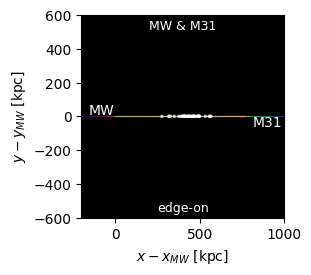

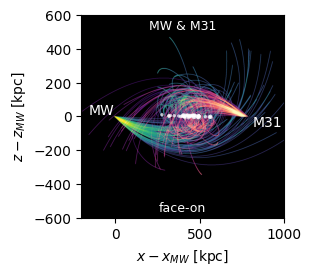

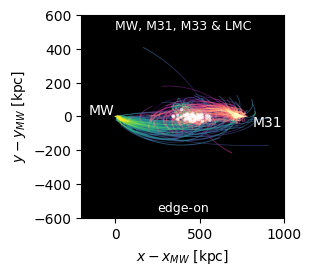

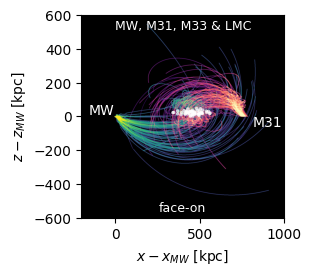

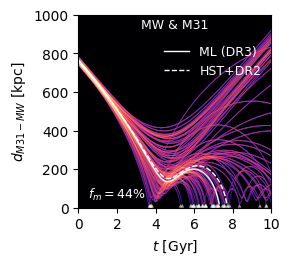

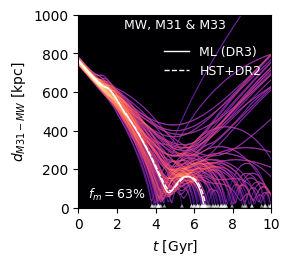

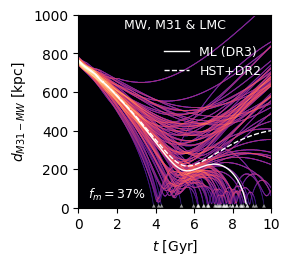

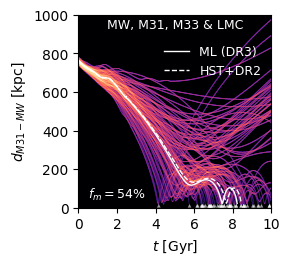

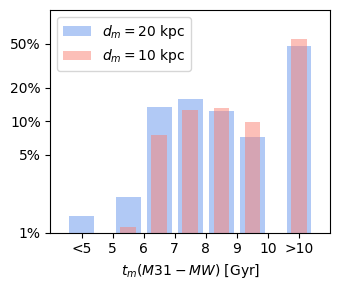

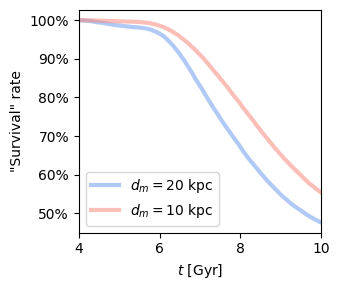

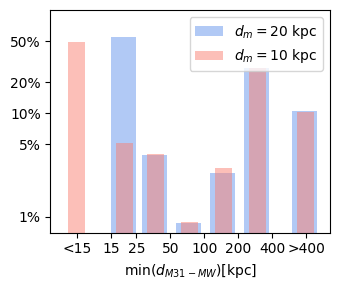

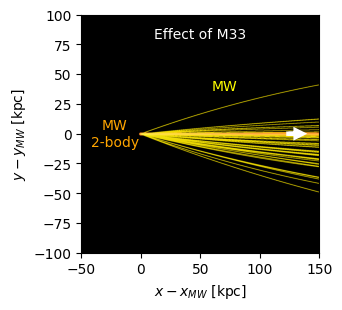

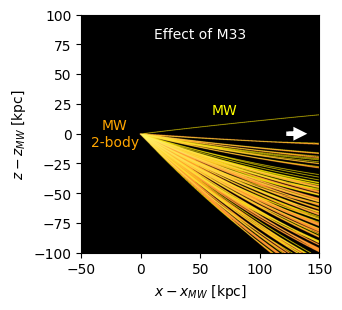

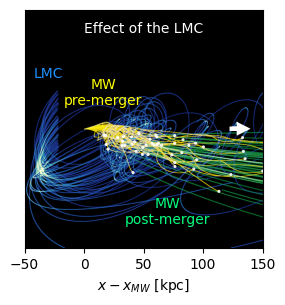

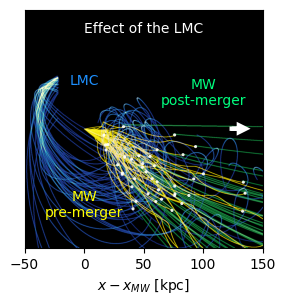

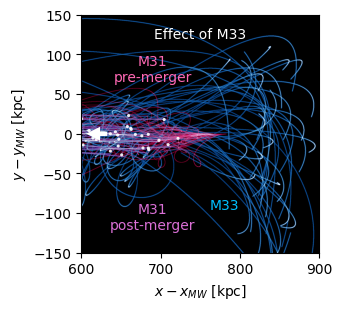

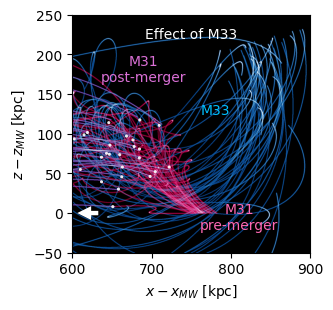

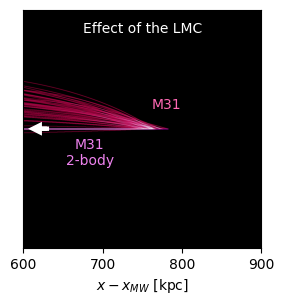

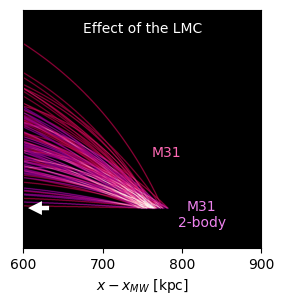

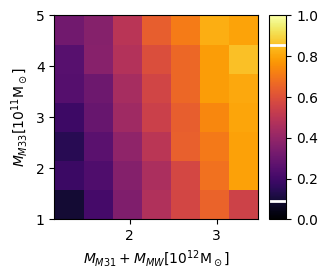

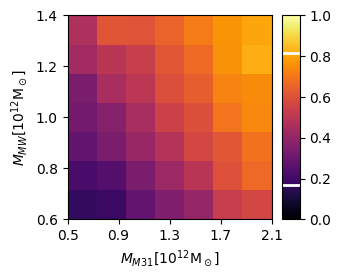

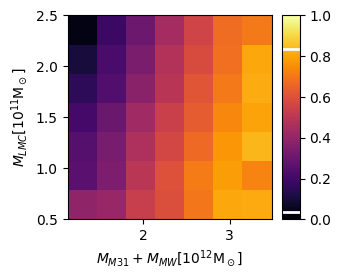

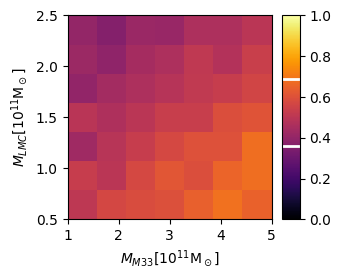

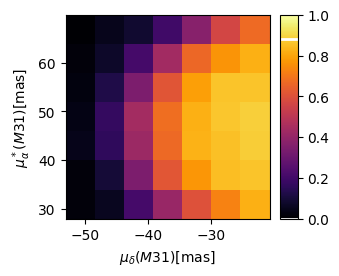

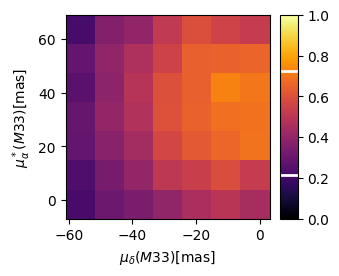

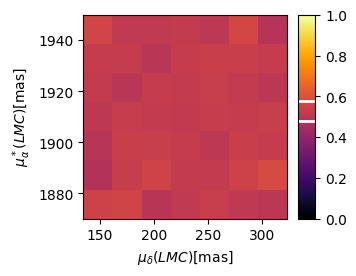

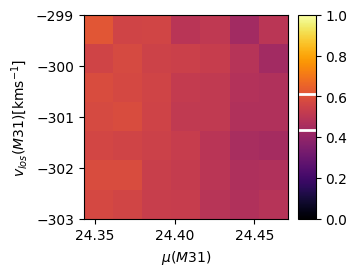

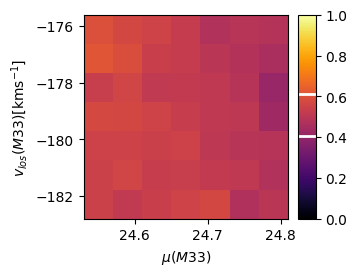

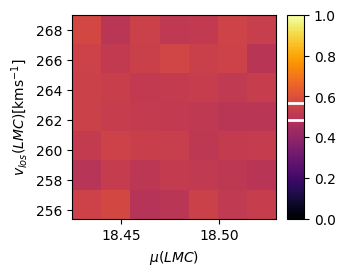

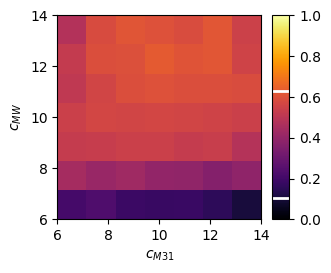

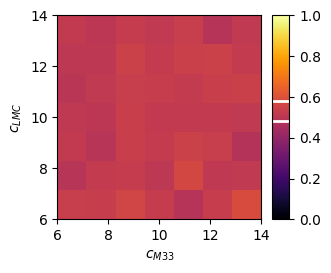

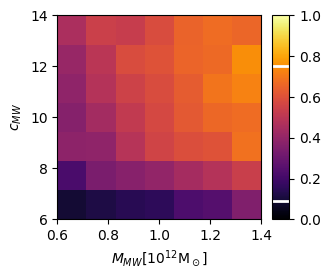

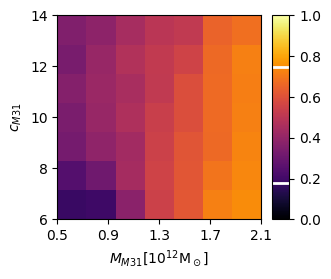

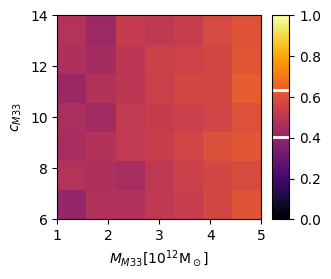

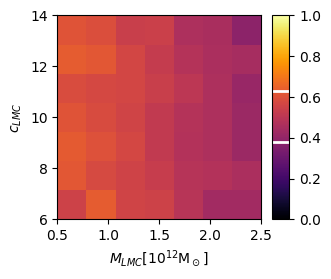

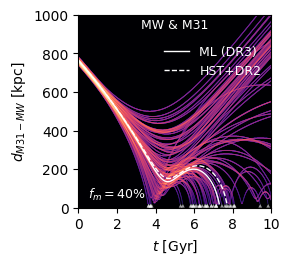

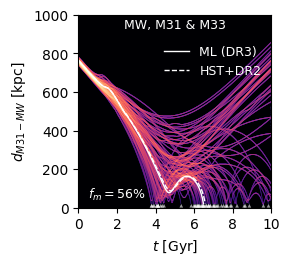

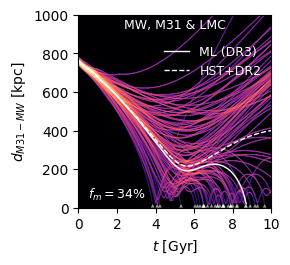

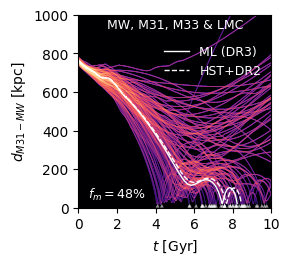

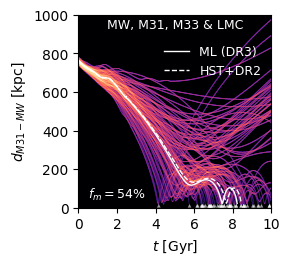

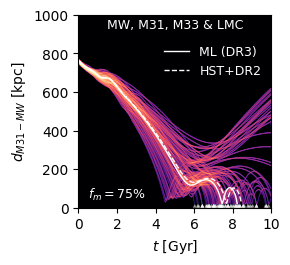

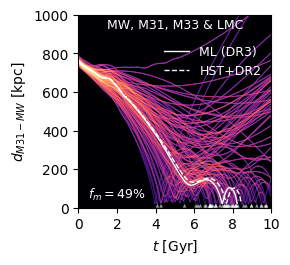

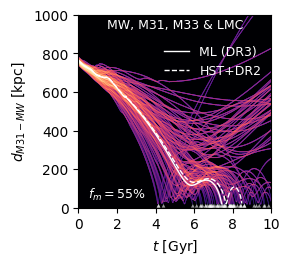

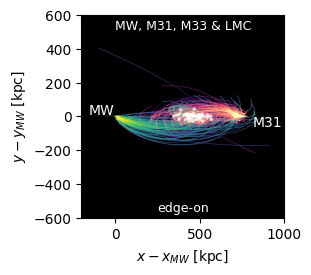

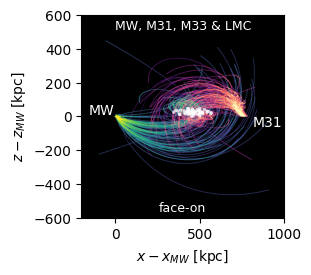

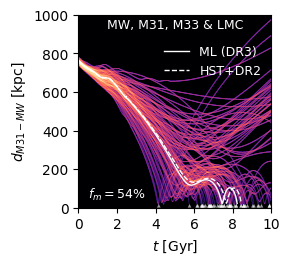

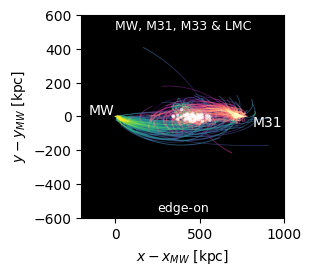

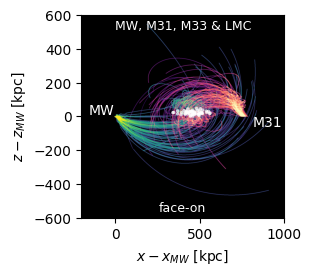

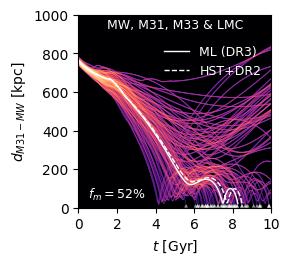

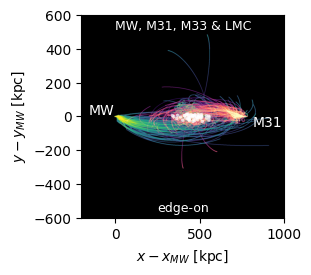

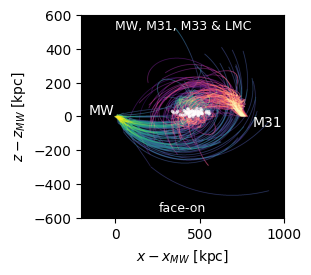

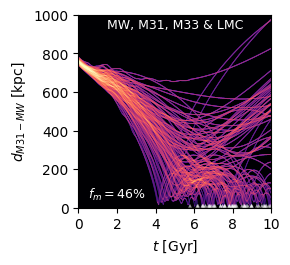

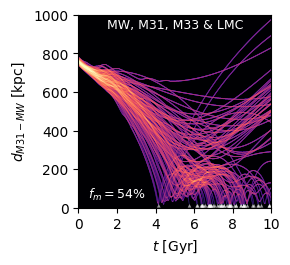

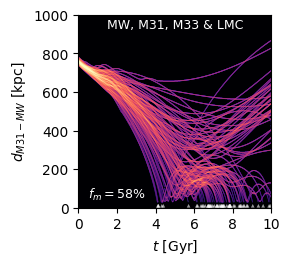

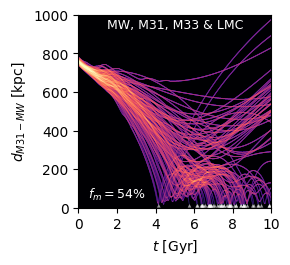

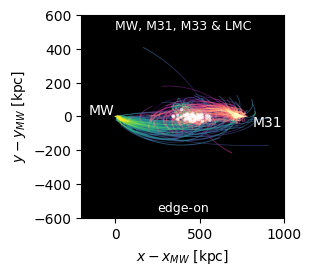

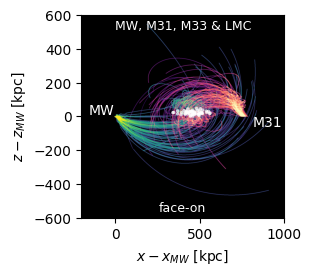

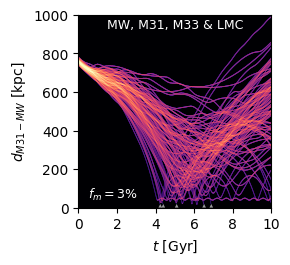

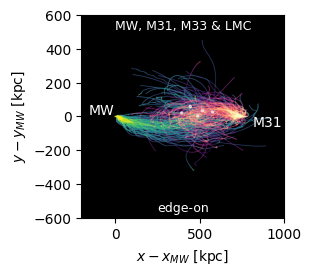

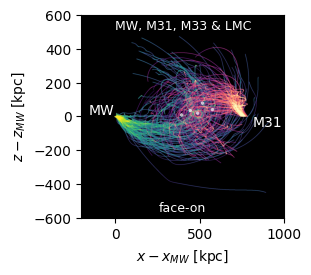

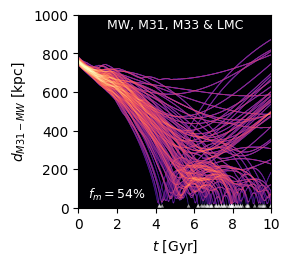

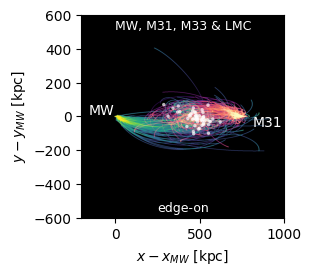

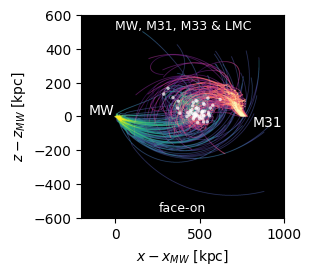

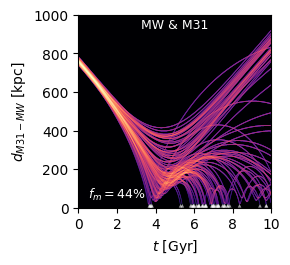

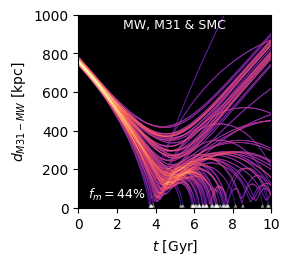

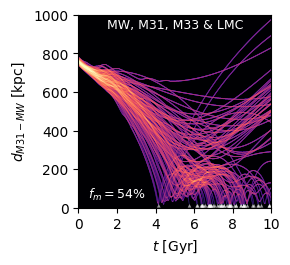

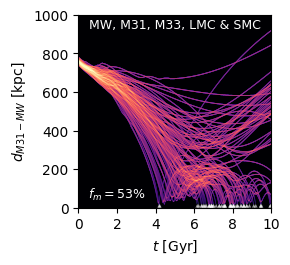

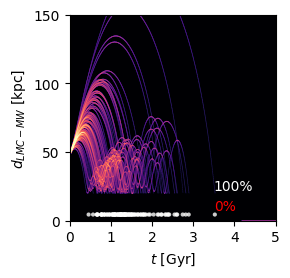

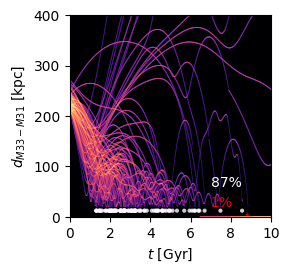

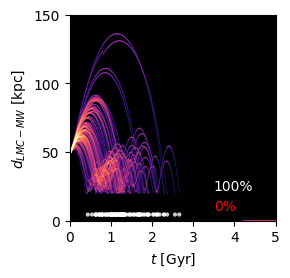

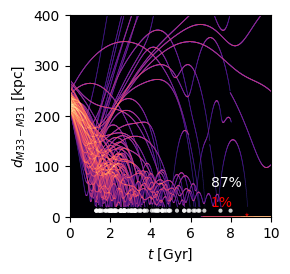

In [27]:
calculate_orbits = False
save_orbits = False
save_observables = False

N_orbits = 100
N_stats = 2500

plots_root = "figures"

try:  
    os.mkdir(plots_root)  
except OSError as error:  
    print(error) 


# Figure 1 (orbit heatmaps)

plots_dir = plots_root+'/figure_1'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'M33','LMC']]
variant = 'fiducial'
dynamical_friction = 'proportional'
softening = 20 
merger_threshold = 20 
clip_sigma = 2.0

for galaxies in galaxies_sets:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']

    plot_heatmap_MW_M31(orbits, vels, summary_data, suffix)
    

# Figure 2 (distances)

plots_dir = plots_root+'/figure_2'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'M33'], ['MW', 'M31', 'LMC'], ['MW', 'M31', 'M33','LMC']]
variant = 'fiducial'
dynamical_friction = 'proportional'
softening = 20 
merger_threshold = 20 
clip_sigma = 2.0

for galaxies in galaxies_sets:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']

    plot_distances_compare(galaxies, orbits, summary_data, suffix) 


# Figure 3 (1d-distributions)

plots_dir = plots_root+'/figure_3'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

N_s = 50000
plot_distributions()


# Figure 4 (Effect of satellites on the MW)

plots_dir = plots_root+'/figure_4'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31', 'M33'], ['MW', 'M31', 'LMC']]
variant = 'fiducial'
dynamical_friction = 'proportional'
softening = 20 
merger_threshold = 20 
clip_sigma = 2.0

for galaxies in galaxies_sets:

    print ("galaxies:", galaxies)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']
    
    orbit_data_alt = read_orbit_data(['MW','M31'], variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    orbits_alt = orbit_data_alt['orbits']
    
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    plot_LMC_and_MW_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix)


# Figure 5 (Effect of satellites on M31)

plots_dir = plots_root+'/figure_5'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31', 'M33'], ['MW', 'M31', 'LMC']]
variant = 'fiducial'
dynamical_friction = 'proportional'
softening = 20 
merger_threshold = 20 
clip_sigma = 2.0

for galaxies in galaxies_sets:

    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']
    
    orbit_data_alt = read_orbit_data(['MW','M31'], variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    orbits_alt = orbit_data_alt['orbits']
    
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    plot_M33_and_M31_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix)


# Figure 6 (2d outcomes) and Extended Data Figure 3

plots_dir = plots_root+'/figure_6'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

N_s = 50000
plot_2d_outcomes()



# Extended Data Figure 1: HST+DR2 proper motions

plots_dir = plots_root+'/ext_figure_1'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'M33'], ['MW', 'M31', 'LMC'], ['MW', 'M31', 'M33','LMC']]
variant = 'vdM2019'
dynamical_friction = 'proportional'
softening = 20 
merger_threshold = 20 
clip_sigma = 2.0


for galaxies in galaxies_sets:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']

    plot_distances_compare(galaxies, orbits, summary_data, suffix) 


# Extended Data Figure 2 (truncations) 

plots_dir = plots_root+'/ext_figure_2'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies = ['MW', 'M31', 'M33','LMC']
clip_sigmas = [2.0, 1.0, 1000000000]
variant = 'fiducial'
dynamical_friction = 'proportional'
softening = 20 
merger_threshold = 20 

for clip_sigma in clip_sigmas:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']

    plot_distances_compare(galaxies, orbits, summary_data, suffix) 



# Extended Data Figure 3: Remaining 2D distributions (already plotted with Figure 6)



# Extended Data Figure 4 (softening)

plots_dir = plots_root+'/ext_figure_4'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31', 'M33','LMC']]
clip_sigma = 2.0
softenings = [10, 20, 30]
variant = 'fiducial'
dynamical_friction = 'proportional'
merger_threshold = 20 

for softening in softenings:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    
    orbits = orbit_data['orbits']
    vels = orbit_data['vels']
    
    plot_distances_compare(galaxies, orbits, summary_data, suffix) 
    plot_heatmap_MW_M31(orbits, vels, summary_data, suffix)


# Extended Data Figure 5 (threshold)

plots_dir = plots_root+'/ext_figure_5'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31', 'M33','LMC']]
dynamical_friction = 'proportional'
merger_thresholds = [10, 20, 30]
clip_sigma = 2.0
softening = 20
variant = 'fiducial'

for merger_threshold in merger_thresholds:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    
    orbits = orbit_data['orbits']
    vels = orbit_data['vels']
    
    plot_distances_MW_M31(galaxies, orbits, summary_data, suffix) 


# Extended Data Figure 6 (dynamical friction) 

plots_dir = plots_root+'/ext_figure_6'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31', 'M33','LMC']]
softening = 20
clip_sigma = 2.0
variant = 'fiducial'
merger_threshold = 20 
dynamical_frictions = ['proportional', 'none', 'hierarchical']


for dynamical_friction in dynamical_frictions:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    
    orbits = orbit_data['orbits']
    vels = orbit_data['vels']
    
    plot_distances_MW_M31(galaxies, orbits, summary_data, suffix) 
    plot_heatmap_MW_M31(orbits, vels, summary_data, suffix)


# Extended Data Figure 7: including the SMC

plots_dir = plots_root+'/ext_figure_7'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'SMC'], ['MW', 'M31', 'M33','LMC'], ['MW', 'M31', 'M33','LMC','SMC']]
variant = 'fiducial'
softening = 20
clip_sigma = 2.0
merger_threshold = 20 
dynamical_friction = 'proportional'

for galaxies in galaxies_sets:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']

    plot_distances_MW_M31(galaxies, orbits, summary_data, suffix) 



# Fate of M33 and the LMC (figures are not shown)

plots_dir = plots_root+'/ext_figure_x'
try:  
    os.mkdir(plots_dir) 
except OSError as error:  
    print(error) 

galaxies = ['MW', 'M31', 'M33','LMC']
clip_sigma = 2.0
variant = 'fiducial'
dynamical_friction = 'proportional'
softening = 20 
merger_threshold = 20 

for galaxies in galaxies_sets:
    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)
    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_orbits)
    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, merger_threshold, softening, N_stats)

    orbits = orbit_data['orbits']
    vels = orbit_data['vels']

    plot_distances_M33_LMC(galaxies, orbits, summary_data, suffix) 


# Compute the very large MC samples needed for statistics and for some figures. <a id='compute_statistics'></a> 

**Only run this cell if you want to modify assumptions, or if you cannot download the data - see notes at the top** 

Running this Cell in serial takes a long time (> 24 hours). It might be more practical to split the calculation among several CPUs, if that's practical.

Except for the data shown in _Figure 3_, we use $N_s = 2500$ for all figures, to give a maximum error in the (binomial) probability of $1\%$ (for a $50\%$ probability, for higher or lower chances, the error is smaller). For _Figure 3_, we use $N_s = 50000$, as we need to also sample outliers.

[Back to the top](#overview)

In [ ]:
calculate_orbits = True
save_orbits = False

try:  
    os.mkdir(orbits_dir)  
except OSError as error:  
    print(error) 


# set the default values
N_s = 2500
softening = 20 
merger_threshold = 20 
clip_sigmas = [2.0]
variants = ['fiducial']
dynamical_frictions = ['proportional']

# Run the default model for all sets of galaxies
galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'M33'],['MW', 'M31', 'LMC'],['MW', 'M31', 'M33','LMC'], ['MW','M31','SMC'], ['MW', 'M31', 'M33','LMC','SMC']]

compute_and_save()


# Run the alternative models only for the full sets of galaxies:
galaxies_sets = [['MW', 'M31', 'M33','LMC']]


# Run with different truncation
clip_sigmas = [1.0, 1000000000]
compute_and_save()

# Reset to default
clip_sigmas = [2.0]


# Run with different softenings
softening = 10 
compute_and_save()

softening = 30
compute_and_save()

# Reset to default
softening = 20


# Run with different dynamical friction schemes
dynamical_frictions = ['hierarchical', 'none']
compute_and_save()

# Reset to default
dynamical_frictions = ['proportional']


# Run with different merger thresholds
merger_threshold = 10 
compute_and_save()

merger_threshold = 30
compute_and_save()

# Reset to default
merger_threshold = 20


# Run with HST+Gaia DR2 (vdM 2019) proper motions
variants = ['vdM2019']
galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'M33'],['MW', 'M31', 'LMC'],['MW', 'M31', 'M33','LMC']]
compute_and_save()

# Reset to default
variants = ['fiducial']

# Run the Fiducial model once with 50,000 samples
galaxies_sets = [['MW', 'M31', 'M33','LMC']]

N_s = 50000
compute_and_save()

# Repeat with a threshold of 10 kpc
merger_threshold = 10
compute_and_save()


### Compute the orbits that are plotted. <a id='compute_orbits'></a> 

**Only run this cell if you cannot download the data - see notes at the top.**

[Back to the top](#overview)

In [ ]:
# choose a value of N_orbits - the same number should also be used in the plotting
N_s = 100

calculate_orbits = True
save_orbits = True

try:  
    os.mkdir(orbits_dir)  
except OSError as error:  
    print(error) 

# set the default values
softening = 20 
merger_threshold = 20 
clip_sigmas = [2.0]
variants = ['fiducial']
dynamical_frictions = ['proportional']

# Run the default model for all sets of galaxies (Figures 1, 2, 4, 5,  Extended Data Figure 8,  Extended Data Figure 9)
galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'M33'],['MW', 'M31', 'LMC'],['MW', 'M31', 'M33','LMC'], ['MW', 'M31','SMC'], ['MW', 'M31', 'M33','LMC','SMC']]

compute_and_save()

# most of the other models are only run for the main set of galaxies:
galaxies_sets = [['MW', 'M31', 'M33','LMC']]

# Run with different truncation 
clip_sigmas = [1.0, 1000000000]
compute_and_save()

# Reset to default
clip_sigmas = [2.0]

# Run with different softenings 
softening = 10 
compute_and_save()

softening = 30
compute_and_save()

# Reset to default
softening = 20

# Run with different dynamical friction schemes
dynamical_frictions = ['hierarchical', 'none']
compute_and_save()

# Reset to default
dynamical_frictions = ['proportional']

# Run with different merger thresholds 
merger_threshold = 10 
compute_and_save()

merger_threshold = 30
compute_and_save()

# Reset to default
merger_threshold = 20

# Run with HST+Gaia DR2 (vdM 2019) proper motions 
variants = ['vdM2019']
galaxies_sets = [['MW', 'M31'],['MW', 'M31', 'M33'],['MW', 'M31', 'LMC'],['MW', 'M31', 'M33','LMC']]
compute_and_save()